In [1]:
from tqdm import tqdm
from google.colab import drive
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')
pd.options.display.max_columns = None
survey_result_preprocessed = pd.read_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/survey_result_preprocessed.csv',encoding='utf-8',index_col=0)
df = survey_result_preprocessed.copy()

# 경로 A 선택하면 1, 경로 B 선택하면 0
df['choice']=df['route_choice'].apply(lambda x:1 if x=='경로 A' else 0)

# 경로 A 속성 - 경로 B 속성 차이
df['cost_diff'] = df['A_cost'] - df['B_cost']
df['ivt_diff'] = df['A_ivt'] - df['B_ivt']
df['ovt_fmlm_diff'] = df['A_ovt_fmlm'] - df['B_ovt_fmlm']
df['ovt_transfer_diff'] = df['A_ovt_transfer'] - df['B_ovt_transfer']

# cost 단위가 너무 큼. 100원당 효용으로 scale 변경.
df['cost_diff']=df['cost_diff']/100

df.head()

Mounted at /content/drive


,ID,survey_block,route_choice,male,age,income,run,A_ovt_fmlm,A_ivt,A_ovt_transfer,A_cost,B_ovt_fmlm,B_ivt,B_ovt_transfer,B_cost,choice,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff
0,0,4,경로 A,True,40세 이상,500만원 이상,1,10,50,10,1500,14,50,10,1750,1,-2.5,0,-4,0
1,0,4,경로 B,True,40세 이상,500만원 이상,2,16,35,8,2250,10,45,6,2000,0,2.5,-10,6,2
2,0,4,경로 B,True,40세 이상,500만원 이상,3,14,40,6,2000,16,40,8,1500,0,5.0,0,-2,-2
3,0,4,경로 B,True,40세 이상,500만원 이상,4,14,45,8,1500,16,35,6,1750,0,-2.5,10,-2,2
4,0,4,경로 B,True,40세 이상,500만원 이상,5,12,40,10,2250,12,40,10,2000,0,2.5,0,0,0


# [1] 데이터 분리

In [2]:
# 경로A/B 선택 분배가 가장 균등한 질문을 찾아보자. = Entropy가 최대인 질문!
question_answer_ratio = pd.DataFrame()
count_df = df.groupby(['survey_block','run'])['choice'].value_counts().reset_index()

for i in range(len(count_df)):
    index = i // 2
    if count_df.loc[i, 'choice'] == 0:
        question_answer_ratio.loc[index, 'survey_block'] = count_df.loc[i, 'survey_block']
        question_answer_ratio.loc[index, 'run'] = count_df.loc[i, 'run']
        question_answer_ratio.loc[index, 'choice_0'] = count_df.loc[i, 'count']
    else:
        question_answer_ratio.loc[index, 'choice_1'] = count_df.loc[i, 'count']

# Entropy 계산
p_0 = question_answer_ratio['choice_0'] / (question_answer_ratio['choice_0'] + question_answer_ratio['choice_1'])
p_1 = 1 - p_0
question_answer_ratio['Entropy'] = -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
question_answer_ratio.sort_values(by='Entropy', ascending=False).head(15)

,survey_block,run,choice_0,choice_1,Entropy
31,4.0,8.0,28.0,29.0,0.999778
26,4.0,3.0,30.0,27.0,0.998001
30,4.0,7.0,31.0,26.0,0.994442
14,2.0,7.0,22.0,31.0,0.979098
3,1.0,4.0,37.0,18.0,0.912116
15,2.0,8.0,16.0,37.0,0.883585
5,1.0,6.0,16.0,39.0,0.869893
25,4.0,2.0,42.0,15.0,0.831474
2,1.0,3.0,14.0,41.0,0.818403
27,4.0,4.0,43.0,14.0,0.804252


In [3]:
# 각 block별로 Entropy가 가장 큰 run에 해당하는 선택상황을 test data로 분리

df_test = df[((df['survey_block'] == 1) & (df['run'] == 4)) |
             ((df['survey_block'] == 2) & (df['run'] == 7)) |
             ((df['survey_block'] == 3) & (df['run'] == 4)) |
             ((df['survey_block'] == 4) & (df['run'] == 8))]

df_ref = df[~df.index.isin(df_test.index)].reset_index(drop=True)
df_test.reset_index(drop=True, inplace=True)
print(df_test.shape, df_ref.shape)

(204, 20) (1428, 20)


In [4]:
# baseline(train), update, reference 분리
seed = 42
np.random.seed(seed)

List = []
for i in range(204):
    List.extend(np.random.permutation(range(1, 8)).tolist())
df_ref['run_random']  = List

# train (run_random = 1)
df_train = df_ref[df_ref.run_random==1].reset_index(drop=True)
# update (run_random = 2~7)
df_update = df_ref[df_ref['run_random'].isin([2,3,4,5,6,7])].reset_index(drop=True)

print(df_train.shape, df_update.shape, df_test.shape, df_ref.shape)

(204, 21) (1224, 21) (204, 20) (1428, 21)


# [2] Baseline / Reference model 추정

In [5]:
feature_list = ['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff']
baseline_model = smf.logit('choice ~ cost_diff + ivt_diff + ovt_fmlm_diff + ovt_transfer_diff -1', data=df_train)
baseline_result = baseline_model.fit()

print(baseline_result.summary())

Optimization terminated successfully.
         Current function value: 0.391880
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  204
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Nov 2024   Pseudo R-squ.:                  0.4346
Time:                        01:31:25   Log-Likelihood:                -79.943
converged:                       True   LL-Null:                       -141.39
Covariance Type:            nonrobust   LLR p-value:                 1.834e-26
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
cost_diff            -0.2439      0.056     -4.370      0.000      -0.353      -0.135
ivt_diff

In [6]:
reference_model = smf.logit('choice ~ cost_diff + ivt_diff + ovt_fmlm_diff + ovt_transfer_diff -1', data=df_ref)
reference_result = reference_model.fit()

print(reference_result.summary())

Optimization terminated successfully.
         Current function value: 0.359962
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                 1428
Model:                          Logit   Df Residuals:                     1424
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Nov 2024   Pseudo R-squ.:                  0.4787
Time:                        01:31:25   Log-Likelihood:                -514.03
converged:                       True   LL-Null:                       -986.02
Covariance Type:            nonrobust   LLR p-value:                2.533e-204
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
cost_diff            -0.3519      0.025    -14.085      0.000      -0.401      -0.303
ivt_diff

# [3] Updating

In [7]:
def normal_pdf(x, mu, sigma2):
    return (1 / (np.sqrt(2 * np.pi * sigma2))) * np.exp(-((x - mu) ** 2) / (2 * sigma2))

# likelihood 함수 정의 (n번째 사람의 새로운 상황에 대한 choice가 주어졌을 떄 기존에 추정한 beta값 기준 likelihood가 어떻게 나타나는가?)
def likelihood_func(x, update_idx, features, choice, prev_beta_values):

    '''
    Input
    - x : 업데이트될 파라미터 (변수)
    - update_idx : 몇번째 파라미터를 업데이트 할 것인지? (0: cost, 1:ivt, 2:ovt_fmlm, 3:ovt_transfer)
    - features : 주어진 상황의 경로A 속성 - 경로B 속성 [cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff]
    - choice : 사람의 선택
    - prev_beta_values : 이전에 추정한 파라미터 [beta_cost, beta_ivt, beta_ovt_fmlm, beta_ovt_transfer]

    Ouput
    - x에 대한 함수
    '''
    beta_cost, beta_ivt, beta_ovt_fmlm, beta_ovt_transfer = prev_beta_values
    cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features

    if update_idx==0:
      utility_diff = x*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    elif update_idx==1:
      utility_diff = beta_cost*cost_diff + x*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    elif update_idx==2:
      utility_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + x*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    elif update_idx==3:
      utility_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + x*ovt_transfer_diff

    if choice == 1: # A 선택
      prob = 1/(1+np.exp(-utility_diff))
    else: # B 선택
      prob = 1/(1+np.exp(utility_diff))

    return prob

# 파라미터 업데이트 후의 posterior 분포 함수 정의
def posterior(x, last_updated_mean, last_updated_sigma2, update_idx, features, choice, prev_beta_values):
    # prior distribution는 업데이트할 파라미터에 대한  N~(last_updated_mean, last_updated_sigma2)
    prior = normal_pdf(x, last_updated_mean, last_updated_sigma2)
    # 사전에 정의한 likelihood
    likelihood = likelihood_func(x, update_idx, features, choice, prev_beta_values)
    return prior * likelihood


# 사람에 따라 업데이트 후의 파라미터(x) : prior*likelihood(posterior)에서 평균, 분산 찾기
def find_x(id, n, last_updated_mean, last_updated_sigma2, update_idx, prev_beta_values):
   # 지정 ID의 n번째 업데이트 (n=1~6)
   df_update_ID = df_update[df_update.ID == id].sort_values(by='run_random').reset_index(drop=True)
   features = [df_update_ID.loc[n-1,feature] for feature in feature_list]
   choice = df_update_ID.loc[n-1, 'choice']

   x_values = np.linspace(-1, 0, 500)
   posterior_values = [
      posterior(x, last_updated_mean, last_updated_sigma2, update_idx, features, choice, prev_beta_values) for x in x_values
   ]
   posterior_probs = posterior_values / np.sum(posterior_values)

   posterior_mean = np.sum(x_values*posterior_probs) # 업데이트 된 mean (~beta)
   posterior_variance = np.sum((x_values - posterior_mean) ** 2 * posterior_probs) # 업데이트 된 sigma2

   return posterior_mean, posterior_variance

In [8]:
# 결과 저장용 DataFrame 초기화
columns = ['ID', 'baseline'] + [f'update_{x+1}' for x in range(6)]
cost_mean_update_result = pd.DataFrame(columns=columns)
cost_sigma2_update_result = pd.DataFrame(columns=columns)
ivt_mean_update_result = pd.DataFrame(columns=columns)
ivt_sigma2_update_result = pd.DataFrame(columns=columns)
ovt_fmlm_mean_update_result = pd.DataFrame(columns=columns)
ovt_fmlm_sigma2_update_result = pd.DataFrame(columns=columns)
ovt_transfer_mean_update_result = pd.DataFrame(columns=columns)
ovt_transfer_sigma2_update_result = pd.DataFrame(columns=columns)

mean_df_list = [cost_mean_update_result, ivt_mean_update_result, ovt_fmlm_mean_update_result, ovt_transfer_mean_update_result]
sigma2_df_list = [cost_sigma2_update_result, ivt_sigma2_update_result, ovt_fmlm_sigma2_update_result, ovt_transfer_sigma2_update_result]

# 각 파라미터에 대한 기본값과 업데이트 루프
for i in tqdm(range(204)):
    # ID 및 baseline 설정
    update_dfs  = [(mean_df_list[idx],sigma2_df_list[idx],baseline_result.params.values[idx],baseline_result.bse.values[idx]**2*204) for idx in range(4)]

    # 데이터프레임에 ID와 baseline 값 추가
    for mean_df, sigma2_df, baseline_mean, baseline_sigma2 in update_dfs:
        mean_df.loc[i, 'ID'] = i
        mean_df.loc[i, 'baseline'] = baseline_mean
        sigma2_df.loc[i, 'ID'] = i
        sigma2_df.loc[i, 'baseline'] = baseline_sigma2

    # Posterior 업데이트
    prev_means = [baseline_result.params.values[update_idx] for update_idx in range(4)]
    prev_variances = [baseline_result.bse.values[update_idx]**2*204 for update_idx in range(4)]

    for x in range(6):
        # 각 변수 업데이트
        for idx, (mean_df, sigma2_df, prev_mean, prev_variance) in enumerate(zip(mean_df_list, sigma2_df_list, prev_means, prev_variances)):

            posterior_mean, posterior_variance = find_x(id=i,
                                                        n=x+1,
                                                        last_updated_mean=prev_mean,
                                                        last_updated_sigma2=prev_variance,
                                                        update_idx=idx,
                                                        prev_beta_values=prev_means)

            mean_df.loc[i, f'update_{x+1}'] = posterior_mean
            sigma2_df.loc[i, f'update_{x+1}'] = posterior_variance

            # 다음 업데이트를 위한 이전 값 설정
            prev_means[idx] = posterior_mean
            prev_variances[idx] = posterior_variance

# 204 안 곱하면, 업데이트해도 정답률 변화없음!!!

100%|██████████| 204/204 [00:36<00:00,  5.52it/s]


# [4] Test data에 대한 모델의 Accuracy 확인

In [9]:
# 모델에 따른 utility_diff 함수 정의
def utility_diff(model_result, features):
    '''
    Input
    - model_result : 사용할 모델의 결과
    - features : 주어진 상황의 경로 A - 경로 B [cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff]
    Ouput
    - df_ref로 추정한 reference model에 따른 utility diff
    '''
    beta_cost, beta_ivt, beta_ovt_fmlm, beta_ovt_transfer = [model_result.params.values[i] for i in range(4)]
    cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features
    utility_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    return utility_diff

## 4-1. Reference Model

In [10]:
def cross_entropy_loss(y_true, y_pred):
    sum_cross_entropy = 0
    for i in range(len(y_true)):
      if y_true[i] ==1:
        cross_entropy = -np.log(y_pred[i])
        sum_cross_entropy += cross_entropy
      else:
        cross_entropy = -np.log(1-y_pred[i])
        sum_cross_entropy += cross_entropy

    mean_loss = sum_cross_entropy / len(y_true)
    return mean_loss


In [11]:
# GT choice : 실제로 사람들이 random_run8에서 응답한 choice
gt_choice = df_test['choice'].to_list()

# ID 0번부터 203번까지 reference model에 적용했을 때의 prob (ref_prob)와 그에 따른 choice(ref_choice)를 구해보자.
ref_prob = []
ref_choice = []
for id in range(204):
    df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
    features = list(df_test_ID.iloc[0,0:4].values)
    u_diff = utility_diff(reference_result, features)
    prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률
    ref_prob.append(prob)
    ref_choice.append(1 if prob>=0.5 else 0)

# reference model의 정답률 확인
cnt = 0
for i in range(204):
    cnt += (gt_choice[i] == ref_choice[i]) # reference model이 맞출때마다 cnt +1
print('Reference Model Result')
print(f'정답 갯수 : {cnt}, 정답률 : {cnt/204 * 100:.3f}%')

ref_accuracy = cnt/204 * 100
ref_ce = cross_entropy_loss(gt_choice,ref_prob)

Reference Model Result
정답 갯수 : 121, 정답률 : 59.314%


## 4-2. Baseline Model

In [12]:
# ID 0번부터 203번까지 baseline model에 적용했을 때의 prob (baseline_prob)와 그에 따른 choice(baseline_choice)를 구해보자.
baseline_prob = []
baseline_choice = []
for id in range(204):
    df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
    features = list(df_test_ID.iloc[0,0:4].values)
    u_diff = utility_diff(baseline_result, features)
    prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률
    baseline_prob.append(prob)
    baseline_choice.append(1 if prob>=0.5 else 0)

# baseline model의 정답률 확인
cnt = 0
for i in range(204):
    cnt += (gt_choice[i] == baseline_choice[i])
print('Baseline Model Result')
print(f'정답 갯수 : {cnt}, 정답률 : {cnt/204 * 100:.3f}%')

updated_accuracy = [cnt/204 * 100]
updated_ce = [cross_entropy_loss(gt_choice,baseline_prob)]

Baseline Model Result
정답 갯수 : 120, 정답률 : 58.824%


## 4-3. Updated Model

In [13]:
# 계속해서 업데이트 되면서 정답률 얼마나 바뀌는지 확인
print('Updated Model Result')
for i in range(6):
  updated_prob = []
  updated_choice = []
  for id in range(204):
      df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
      features = list(df_test_ID.iloc[0,0:4].values)

      beta_cost = cost_mean_update_result[f'update_{i+1}'][id]
      beta_ivt = ivt_mean_update_result[f'update_{i+1}'][id]
      beta_ovt_fmlm = ovt_fmlm_mean_update_result[f'update_{i+1}'][id]
      beta_ovt_transfer = ovt_transfer_mean_update_result[f'update_{i+1}'][id]
      cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features

      u_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
      prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률

      updated_prob.append(prob)
      updated_choice.append(1 if prob>=0.5 else 0)
  cnt = 0
  for i in range(204):
      cnt += (gt_choice[i] == updated_choice[i])

  print(f'정답 갯수 : {cnt}, 정답률 : {cnt/204 * 100:.3f}%')
  updated_accuracy.append(cnt/204 * 100)
  updated_ce.append(cross_entropy_loss(gt_choice,updated_prob))

Updated Model Result
정답 갯수 : 126, 정답률 : 61.765%
정답 갯수 : 123, 정답률 : 60.294%
정답 갯수 : 129, 정답률 : 63.235%
정답 갯수 : 136, 정답률 : 66.667%
정답 갯수 : 134, 정답률 : 65.686%
정답 갯수 : 140, 정답률 : 68.627%


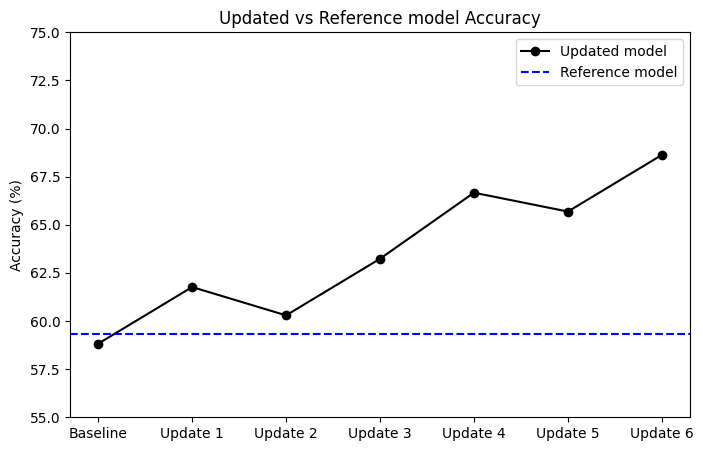

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(range(7), updated_accuracy, marker='o', color='black',label='Updated model')
plt.axhline(y=ref_accuracy, color='blue', linestyle='--',label='Reference model')
plt.title('Updated vs Reference model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xticks(range(7),['Baseline','Update 1','Update 2','Update 3','Update 4','Update 5','Update 6'])
plt.ylim(55, 75)
plt.legend()
plt.show()

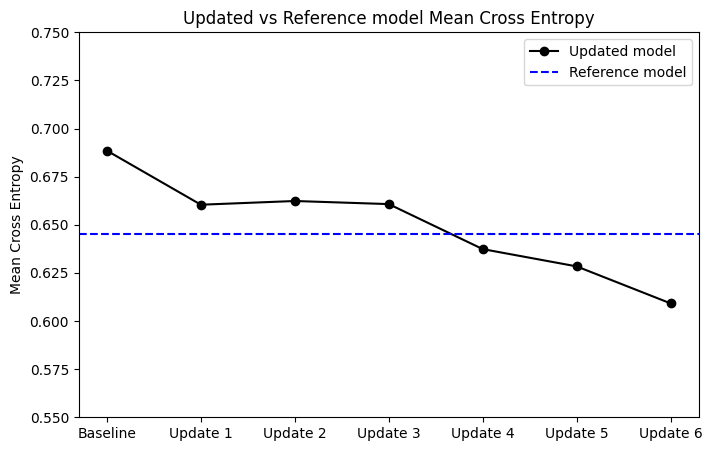

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(range(7), updated_ce, marker='o', color='black',label='Updated model')
plt.axhline(y=ref_ce, color='blue', linestyle='--',label='Reference model')
plt.title('Updated vs Reference model Mean Cross Entropy')
plt.ylabel('Mean Cross Entropy')
plt.ylim(0.55,0.75)
plt.xticks(range(7),['Baseline','Update 1','Update 2','Update 3','Update 4','Update 5','Update 6'])
plt.legend()
plt.show()

## 4-4. Reference Model vs. Updated Model

In [16]:
import warnings
warnings.filterwarnings(action='ignore')

compare_ref_updated=df_test[['ID','survey_block','run','cost_diff','ivt_diff','ovt_fmlm_diff','ovt_transfer_diff','choice']]

compare_ref_updated['ref_prob']=ref_prob
compare_ref_updated['ref_choice']=ref_choice
compare_ref_updated['updated_prob']=updated_prob
compare_ref_updated['updated_choice']=updated_choice

compare_ref_updated['ref_result']=(compare_ref_updated['choice']==compare_ref_updated['ref_choice'])
compare_ref_updated['updated_result']=(compare_ref_updated['choice']==compare_ref_updated['updated_choice'])

compare_ref_updated['result'] = compare_ref_updated.apply(
    lambda row: 'Both correct' if row['ref_result'] == 1 and row['updated_result'] == 1
    else 'Only ref correct' if row['ref_result'] == 1 and row['updated_result'] == 0
    else 'Only updated correct' if row['ref_result'] == 0 and row['updated_result'] == 1
    else 'Neither correct', axis=1
)
compare_ref_updated['result'].value_counts()

,count
result,
Both correct,107
Neither correct,50
Only updated correct,33
Only ref correct,14


### 4-4-1. Error 비교

In [17]:
# 전체에 대하여
# 맞고 틀리고와 관계 없이 전체 예측에 대하여 error가 작음
compare_all_case = compare_ref_updated.copy()

#choice가 0이면 prob가 0에 가까울수록 잘 예측. choice가 1이면 prob가 1에 가까울수록 잘 예측한것 -> error=|choice-prob|가 작을수록 좋은것
compare_all_case['ref_error']=abs(compare_all_case['choice']-compare_all_case['ref_prob'])
compare_all_case['updated_error']=abs(compare_all_case['choice']-compare_all_case['updated_prob'])
print('Reference model MAE:',round(np.mean(compare_all_case['ref_error']),4))
print('Updated model MAE:',round(np.mean(compare_all_case['updated_error']),4)) # 더 작음
print('\nReference model RMSE:',round(np.mean((compare_all_case['ref_error'])**2),4))
print('Updated model RMSE:',round(np.mean((compare_all_case['updated_error'])**2),4)) # 더 작음

Reference model MAE: 0.4428
Updated model MAE: 0.4006

Reference model RMSE: 0.2271
Updated model RMSE: 0.2099


In [18]:
# 사실 범주형 문제니까 MAE, RMSE라는 metric보다는 cross entropy가 더 낫지 않을까
# 교차 엔트로피는 예측 확률 분포가 실제 분포에 얼마나 가까운지를 평가하므로, 확률 기반 분류 문제

def cross_entropy_loss(y_true, y_pred):
    sum_cross_entropy = 0
    for i in range(len(y_true)):
      if y_true[i] ==1:
        cross_entropy = -np.log(y_pred[i])
        sum_cross_entropy += cross_entropy
      else:
        cross_entropy = -np.log(1-y_pred[i])
        sum_cross_entropy += cross_entropy

    mean_loss = sum_cross_entropy / len(y_true)
    return mean_loss

print('\nReference model mean CE:',round(cross_entropy_loss(compare_all_case['choice'],compare_all_case['ref_prob']),4))
print('Updated model mean CE:',round(cross_entropy_loss(compare_all_case['choice'],compare_all_case['updated_prob']),4)) # 더 작음


Reference model mean CE: 0.6452
Updated model mean CE: 0.6092


In [19]:
# 둘다 맞은 케이스에 대하여
# 똑같이 맞혀도 updated model이 error가 더 작게 맞췄다고 해석가능
both_correct_case = compare_ref_updated[compare_ref_updated['result']=='Both correct'].reset_index(drop=True)

#choice가 0이면 prob가 0에 가까울수록 잘 예측. choice가 1이면 prob가 1에 가까울수록 잘 예측한것 -> error=|choice-prob|가 작을수록 좋은것
both_correct_case['ref_error']=abs(both_correct_case['choice']-both_correct_case['ref_prob'])
both_correct_case['updated_error']=abs(both_correct_case['choice']-both_correct_case['updated_prob'])
print('Reference model MAE:',round(np.mean(both_correct_case['ref_error']),4))
print('Updated model MAE:',round(np.mean(both_correct_case['updated_error']),4)) # 더 작음
print('\nReference model RMSE:',round(np.mean((both_correct_case['ref_error'])**2),4))
print('Updated model RMSE:',round(np.mean((both_correct_case['updated_error'])**2),4)) # 더 작음

Reference model MAE: 0.339
Updated model MAE: 0.2404

Reference model RMSE: 0.1427
Updated model RMSE: 0.0769


In [20]:
print('\nReference model mean CE:',round(cross_entropy_loss(both_correct_case['choice'],both_correct_case['ref_prob']),4))
print('Updated model mean CE:',round(cross_entropy_loss(both_correct_case['choice'],both_correct_case['updated_prob']),4)) # 더 작음


Reference model mean CE: 0.4427
Updated model mean CE: 0.292


In [21]:
# 둘다 틀린 케이스에 대하여
# 한계(?) : 똑같이 틀렸을 때는 오히려 ref.model이 error가 더 작게 틀렸다고 해석가능
# 하지만 둘다 틀렸다는 것은 trash data일 가능성도 무시할 수 없음
neither_correct_case = compare_ref_updated[compare_ref_updated['result']=='Neither correct'].reset_index(drop=True)

#choice가 0이면 prob가 0에 가까울수록 잘 예측. choice가 1이면 prob가 1에 가까울수록 잘 예측한것 -> error=|choice-prob|가 작을수록 좋은것
neither_correct_case['ref_error']=abs(neither_correct_case['choice']-neither_correct_case['ref_prob'])
neither_correct_case['updated_error']=abs(neither_correct_case['choice']-neither_correct_case['updated_prob'])
print('Reference model MAE:',round(np.mean(neither_correct_case['ref_error']),4))
print('Updated model MAE:',round(np.mean(neither_correct_case['updated_error']),4)) # 더 작음
print('\nReference model RMSE:',round(np.mean((neither_correct_case['ref_error'])**2),4))
print('Updated model RMSE:',round(np.mean((neither_correct_case['updated_error'])**2),4)) # 더 작음

Reference model MAE: 0.5928
Updated model MAE: 0.6904

Reference model RMSE: 0.3652
Updated model RMSE: 0.488


In [22]:
print('\nReference model mean CE:',round(cross_entropy_loss(neither_correct_case['choice'],neither_correct_case['ref_prob']),4))
print('Updated model mean CE:',round(cross_entropy_loss(neither_correct_case['choice'],neither_correct_case['updated_prob']),4)) # 더 작음


Reference model mean CE: 0.9915
Updated model mean CE: 1.2721


### 4-4-2. Survey Block별 정오 분포

In [23]:
survey_block_result_distribution = compare_ref_updated.groupby(['survey_block', 'result']).size().unstack(fill_value=0)
survey_block_result_distribution['Total'] = survey_block_result_distribution.sum(axis=1)
survey_block_result_distribution.loc['Total'] = survey_block_result_distribution.sum(axis=0)
survey_block_result_distribution

result,Both correct,Neither correct,Only ref correct,Only updated correct,Total
survey_block,,,,,
1,29,8,8,10,55
2,21,25,1,6,53
3,33,6,0,0,39
4,24,11,5,17,57
Total,107,50,14,33,204


In [24]:
# survey_block별 result 분포를 테이블 형식으로 출력하고 총합 추가 (%로 봄)
survey_block_result_distribution = compare_ref_updated.groupby(['survey_block', 'result']).size().unstack(fill_value=0)
survey_block_result_distribution['Total'] = survey_block_result_distribution.sum(axis=1)
survey_block_result_distribution.loc['Total'] = survey_block_result_distribution.sum(axis=0)
survey_block_result_distribution['Both correct'] = (survey_block_result_distribution['Both correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution['Neither correct'] = (survey_block_result_distribution['Neither correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution['Only updated correct'] = (survey_block_result_distribution['Only updated correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution['Only ref correct'] = (survey_block_result_distribution['Only ref correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution

# 모든 survey block에서 ref_model과 updated_model의 예측 결과가 갈렸을 때, updated_model의 예측 결과가 맞을 확률이 더 높았다.
# 근거: 항상 only ref correct(%) < only updated correct(%)

result,Both correct,Neither correct,Only ref correct,Only updated correct,Total
survey_block,,,,,
1,52.7,14.5,14.5,18.2,55
2,39.6,47.2,1.9,11.3,53
3,84.6,15.4,0.0,0.0,39
4,42.1,19.3,8.8,29.8,57
Total,52.5,24.5,6.9,16.2,204


In [25]:
# block별 정답률 : block3을 제외하고 모든 block에서 updated model의 정답률이 더 높음
for i in range(4):
  temp_df = compare_ref_updated[compare_ref_updated.survey_block==i+1]
  tot = len(temp_df)
  bc = len(temp_df[temp_df.result=='Both correct'])
  orc = len(temp_df[temp_df.result=='Only ref correct'])
  ouc = len(temp_df[temp_df.result=='Only updated correct'])
  print(f'\nblock {i+1}에 대한 updated model의 정답률: {(bc+ouc)/tot*100:.2f}%')
  print(f'block {i+1}에 대한 reference model의 정답률: {(bc+orc)/tot*100:.2f}%')


block 1에 대한 updated model의 정답률: 70.91%
block 1에 대한 reference model의 정답률: 67.27%

block 2에 대한 updated model의 정답률: 50.94%
block 2에 대한 reference model의 정답률: 41.51%

block 3에 대한 updated model의 정답률: 84.62%
block 3에 대한 reference model의 정답률: 84.62%

block 4에 대한 updated model의 정답률: 71.93%
block 4에 대한 reference model의 정답률: 50.88%


#  [5] Parameter Updating에 따른 Beta 분포 변화

In [26]:
def plot_updated_parameters(update_result, update_idx, binwidth=0.01):
  fig, axes = plt.subplots(2,3, figsize=(10,5))
  fig.suptitle(f'Distribution of Updated parameters for {feature[update_idx]}',fontsize=13)

  # x축 범위 설정하기 위하여
  x_min = update_result['update_6'].min()
  x_max = update_result['update_6'].max()
  # y축 범위 설정하기 위하여 1st stage만 그리기
  i, row, col = 1,0,0
  hist = sns.histplot(update_result[f'update_{i}'], binwidth=binwidth, color='grey', kde=True, ax=axes[row, col],stat='probability')
  axes[row,col].axvline(x= baseline_result.params.values[update_idx], ymin=-0, ymax=1, color='orange', linestyle='--', label='baseline')
  axes[row,col].axvline(x= reference_result.params.values[update_idx], ymin=-0, ymax=1, color='green', linestyle='--', label='reference')
  axes[row, col].set_title(f'update_{i}',fontsize=10)
  axes[row, col].set_xlim(x_min, x_max)
  axes[row, col].set_xlabel('')
  y_max = hist.get_ylim()[1]

  axes[row, col].legend(loc='upper left', fontsize=7)

  for i in range(2,7):
    row = (i - 1) // 3
    col = (i - 1) % 3
    sns.histplot(update_result[f'update_{i}'], binwidth=binwidth, color='grey', kde=True, ax=axes[row, col],stat='probability')
    axes[row,col].axvline(x= baseline_result.params.values[update_idx], ymin=-0, ymax=1, color='orange', linestyle='--', label='baseline')
    axes[row,col].axvline(x= reference_result.params.values[update_idx], ymin=-0, ymax=1, color='green', linestyle='--', label='reference')
    axes[row, col].set_title(f'update_{i}',fontsize=10)
    axes[row, col].set_xlim(x_min, x_max)
    axes[row, col].set_ylim(0, y_max)
    axes[row, col].set_xlabel('')
    if i!=4:
      axes[row,col].set_ylabel('')

  plt.tight_layout()
  plt.show()

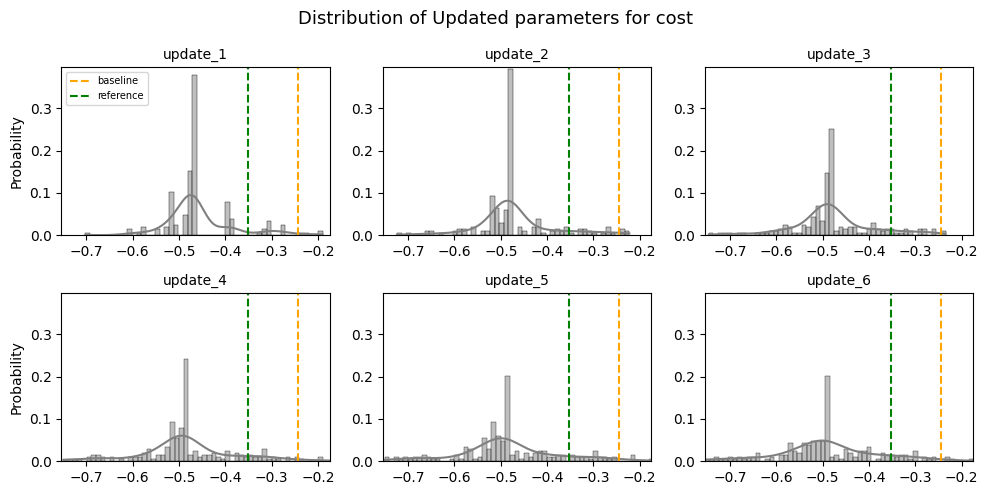

In [27]:
feature=['cost','ivt','ovt_fmlm','ovt_transfer']
plot_updated_parameters(cost_mean_update_result, 0 )

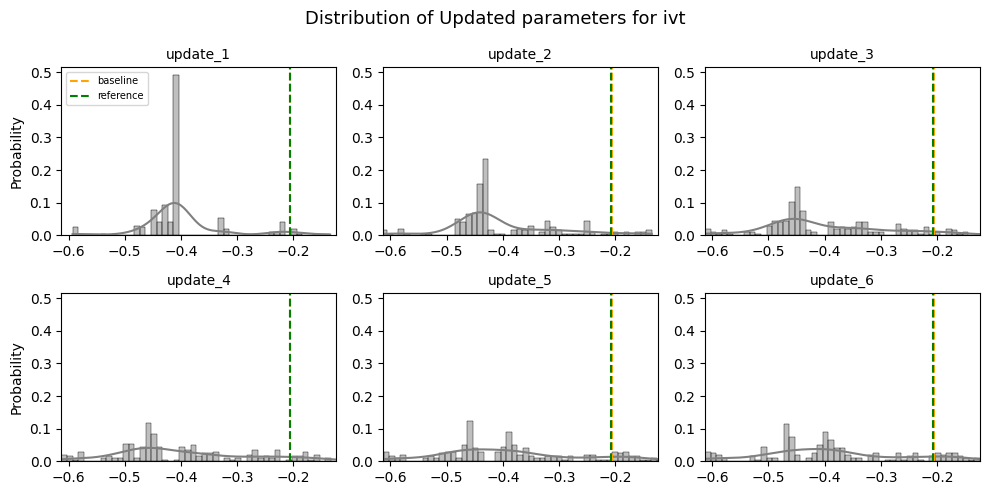

In [28]:
plot_updated_parameters(ivt_mean_update_result,1)

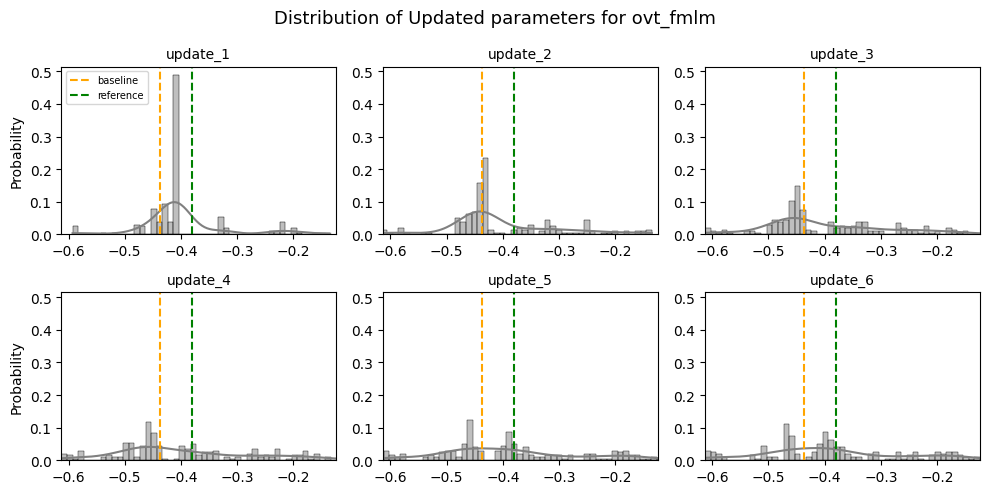

In [29]:
plot_updated_parameters(ivt_mean_update_result,2)

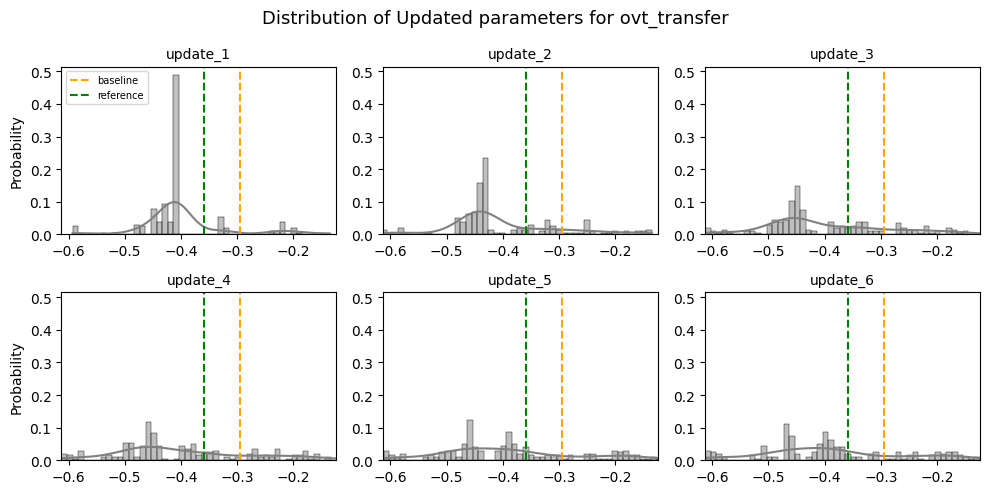

In [30]:
plot_updated_parameters(ivt_mean_update_result,3)

## 5-1. Case study : block **4**

In [31]:
# 한 사람의 계수 변화 보여주는 함수
def plot_updated_parameters(update_result, id):
  fig, axs=plt.subplots(2,2,figsize=(14,10))
  fig.suptitle(f"Time series of Updates for ID {id}")
  for i in range(4):
    data_row = update_result[i][update_result[i]['ID'] == id]
    stages = data_row.columns[1:]
    values = data_row.iloc[0, 1:]

    ax = axs[i // 2, i % 2]
    ax. plot(stages, values, marker='o')
    ax.set_title(feature[i])
    ax.axhline(y=reference_result.params.values[i], color = 'red', linestyle='-',label='reference')
    ax.axhline(y=baseline_result.params.values[i],color='blue', linestyle='-',label='baseline')
    ax.set_ylim(-1,0)
    ax.legend(loc='upper left', fontsize=7)

  plt.tight_layout(rect=[0, 0, 1, 0.95])  # 전체 제목과 subplot 사이 여백 설정
  plt.show()

## prob의 변화를 보여주자
def plot_prob_change(update_result, id):
  updated_prob=[]
  for i in range(1,8):
    beta_cost = update_result[0].iloc[id, i]
    beta_ivt = update_result[1].iloc[id, i]
    beta_ovt_fmlm = update_result[2].iloc[id,i]
    beta_ovt_transfer = update_result[3].iloc[id,i]

    df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
    features = list(df_test_ID.iloc[0,0:4].values)
    cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features

    u_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률

    updated_prob.append(prob)

  plt.figure(figsize=(8,5))
  plt.plot(updated_prob, label='updated')
  plt.axhline(y=compare_ref_updated[compare_ref_updated['ID']==id]['ref_prob'].values, color = 'red', linestyle='-', label='reference')
  plt.axhline(y=0.5, linestyle='--', color='grey')
  plt.xticks([0,1,2,3,4,5,6],['baseline','update_1','update_2','update_3','update_4','update_5','update_6'])
  plt.xlabel('update stage')
  plt.ylabel('prob')
  plt.ylim(0,1)
  plt.title('Compare probability for choice: route A')
  plt.legend()
  plt.show()

# block별 case study
# 1은 ref choice가 항상 0, updated choice는 갈림
# 2는 ref choice가 항상 0, updated choice는 갈림
# 3은 ref choice와 updated choice 모두 항상 0
# 4는 ref choice가 항상 1, updated choice는 갈림

def case_study(block_num,update_result=mean_df_list):
  temp_df = compare_ref_updated[compare_ref_updated.survey_block==block_num]
  cases = ['Both correct', 'Neither correct', 'Only updated correct', 'Only ref correct']

  for case in cases:
    try:
      if (block_num==4)&(case=='Both correct' or case=='Only ref correct'):
        ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').tail(1).reset_index()['ID'][0]
      elif block_num==4:
        ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').head(1).reset_index()['ID'][0]
      elif (case=='Both correct' or case=='Only ref correct'):
        ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').head(1).reset_index()['ID'][0]
      else:
        ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').tail(1).reset_index()['ID'][0]
    except:
      continue

    print(f'\n\nCase Study of Survey Block {block_num} - ID {ID} : {case}')
    plot_updated_parameters(update_result,ID)
    plot_prob_change(update_result,ID)


In [32]:
# 4-8에 대해서 ref_choice는 항상 1
## 모든 case에 대해 이상적인 상황
# both correct는 updated_prob가 더 높아야함.
# neither correct는 updated_prob가 더 낮아야함.
# only updated는 updated_prob가 더 낮아야함.
# only ref는 updated_prob가 높지만, 0.5보다 살짝 낮은 상황이어야함



Case Study of Survey Block 4 - ID 182 : Both correct


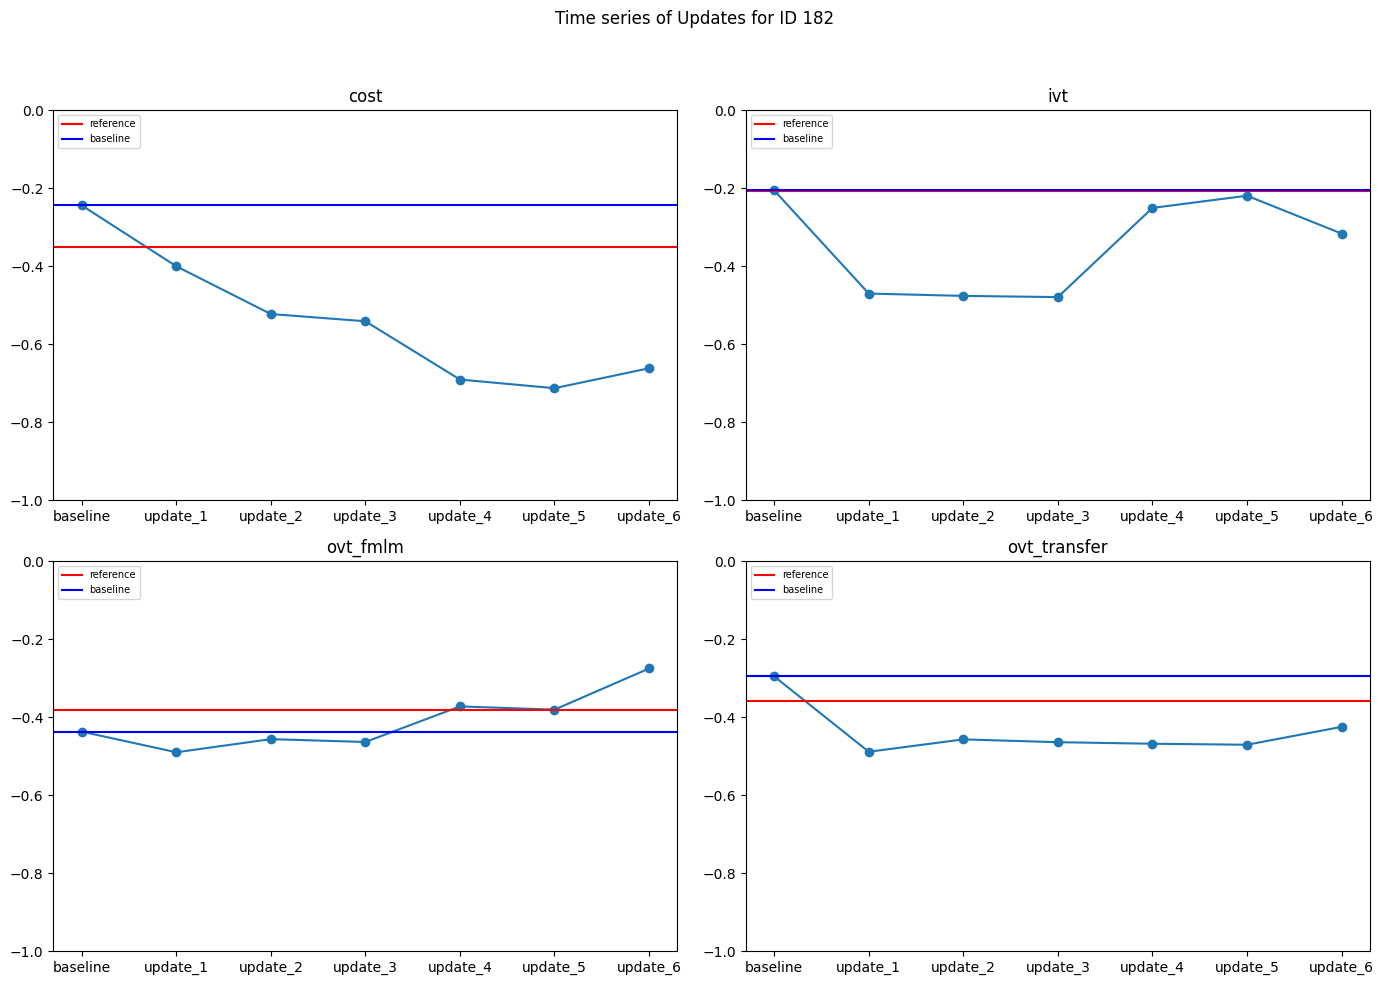

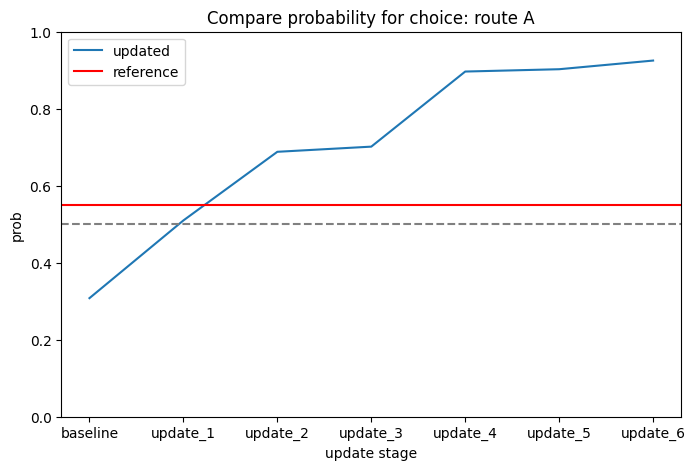



Case Study of Survey Block 4 - ID 176 : Neither correct


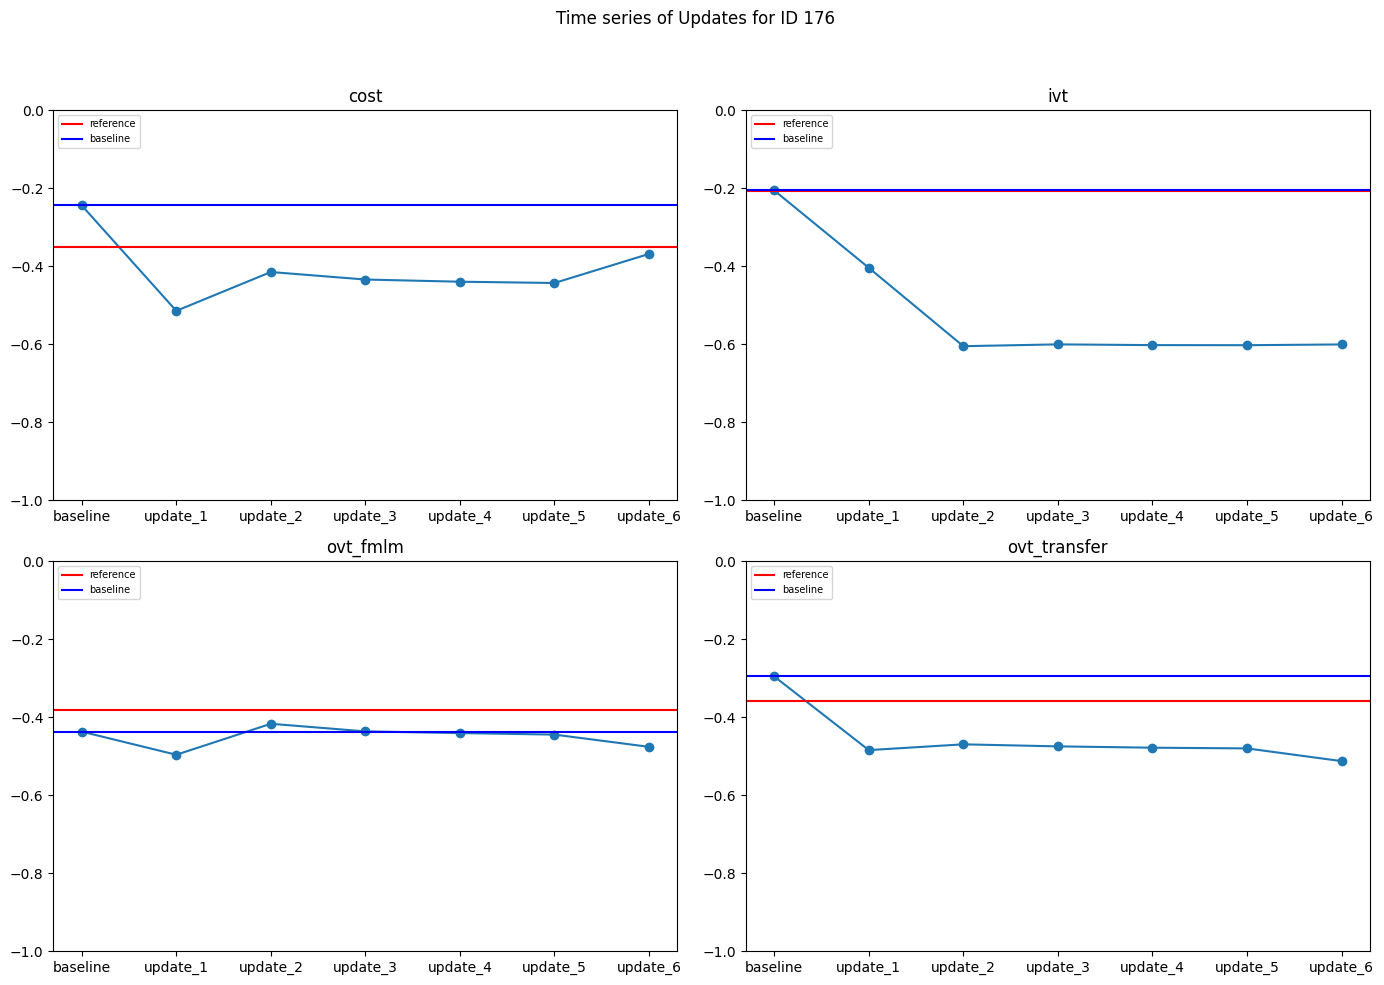

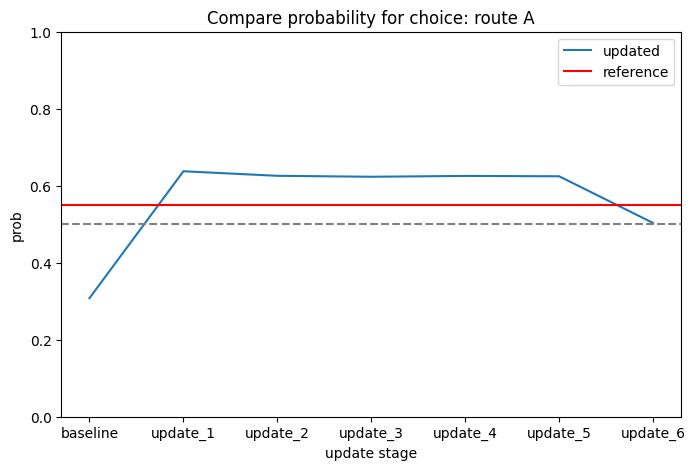



Case Study of Survey Block 4 - ID 32 : Only updated correct


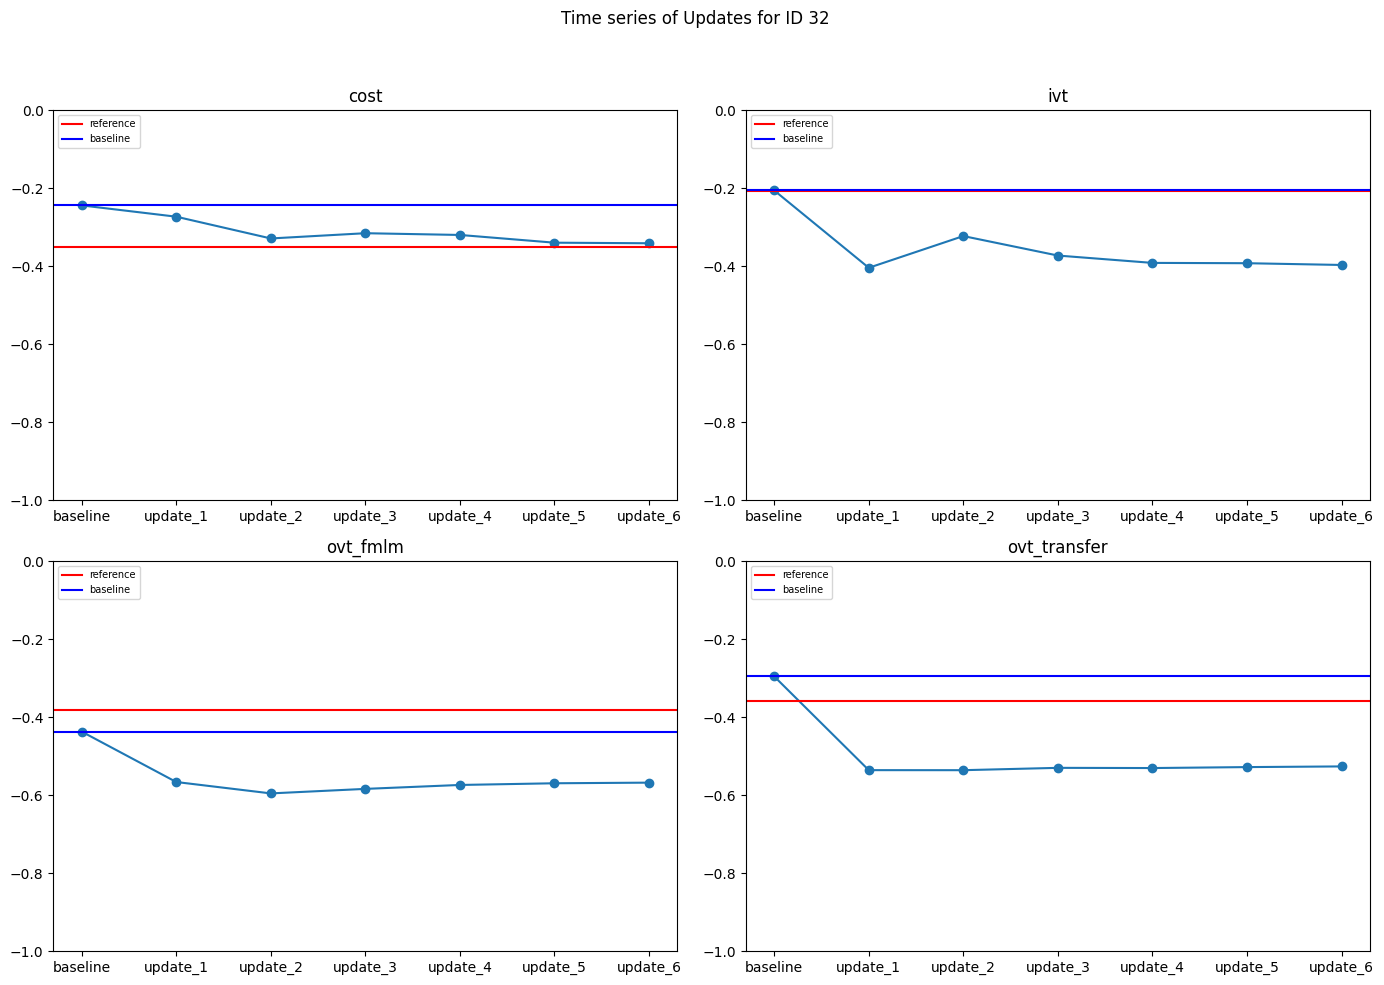

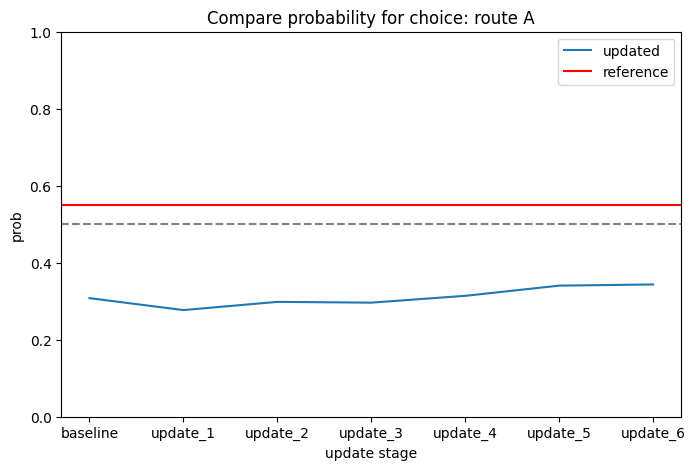



Case Study of Survey Block 4 - ID 106 : Only ref correct


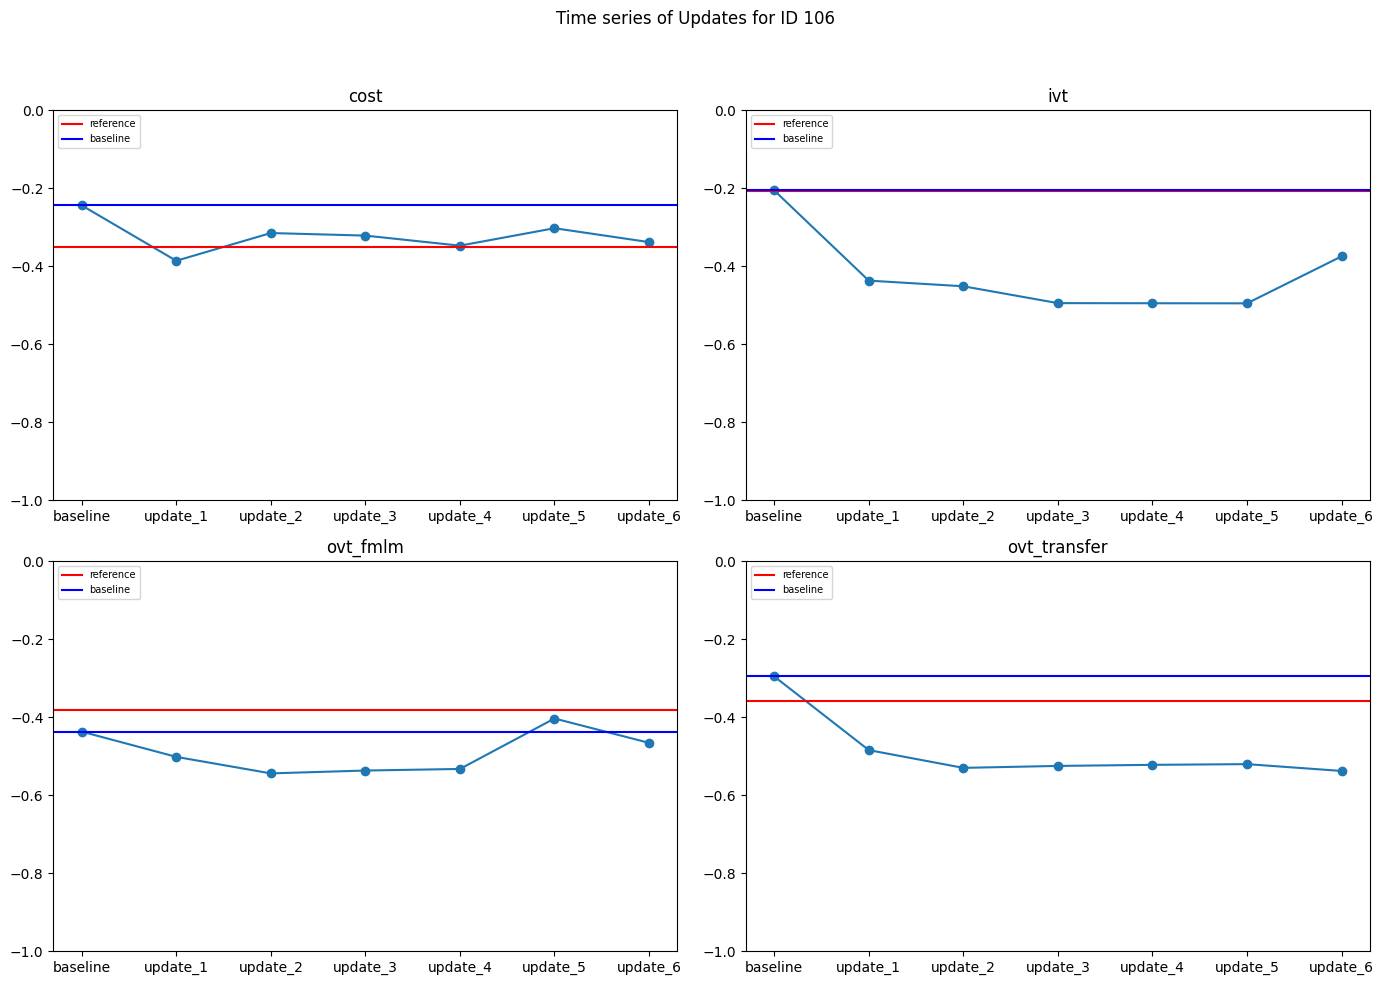

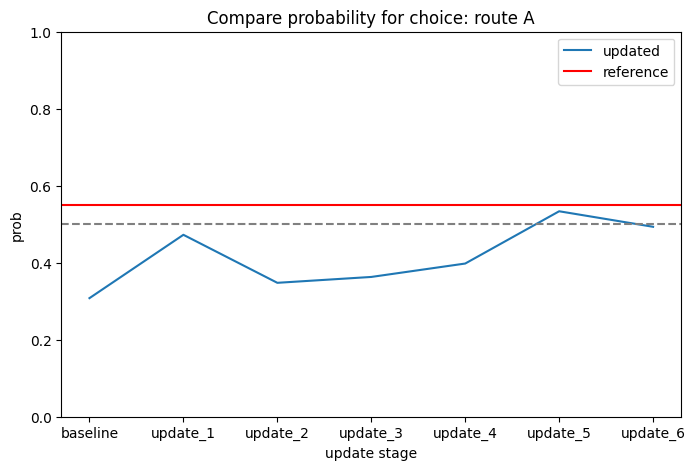

In [33]:
case_study(4)

## 5-2. Case study : block **3**



Case Study of Survey Block 3 - ID 99 : Both correct


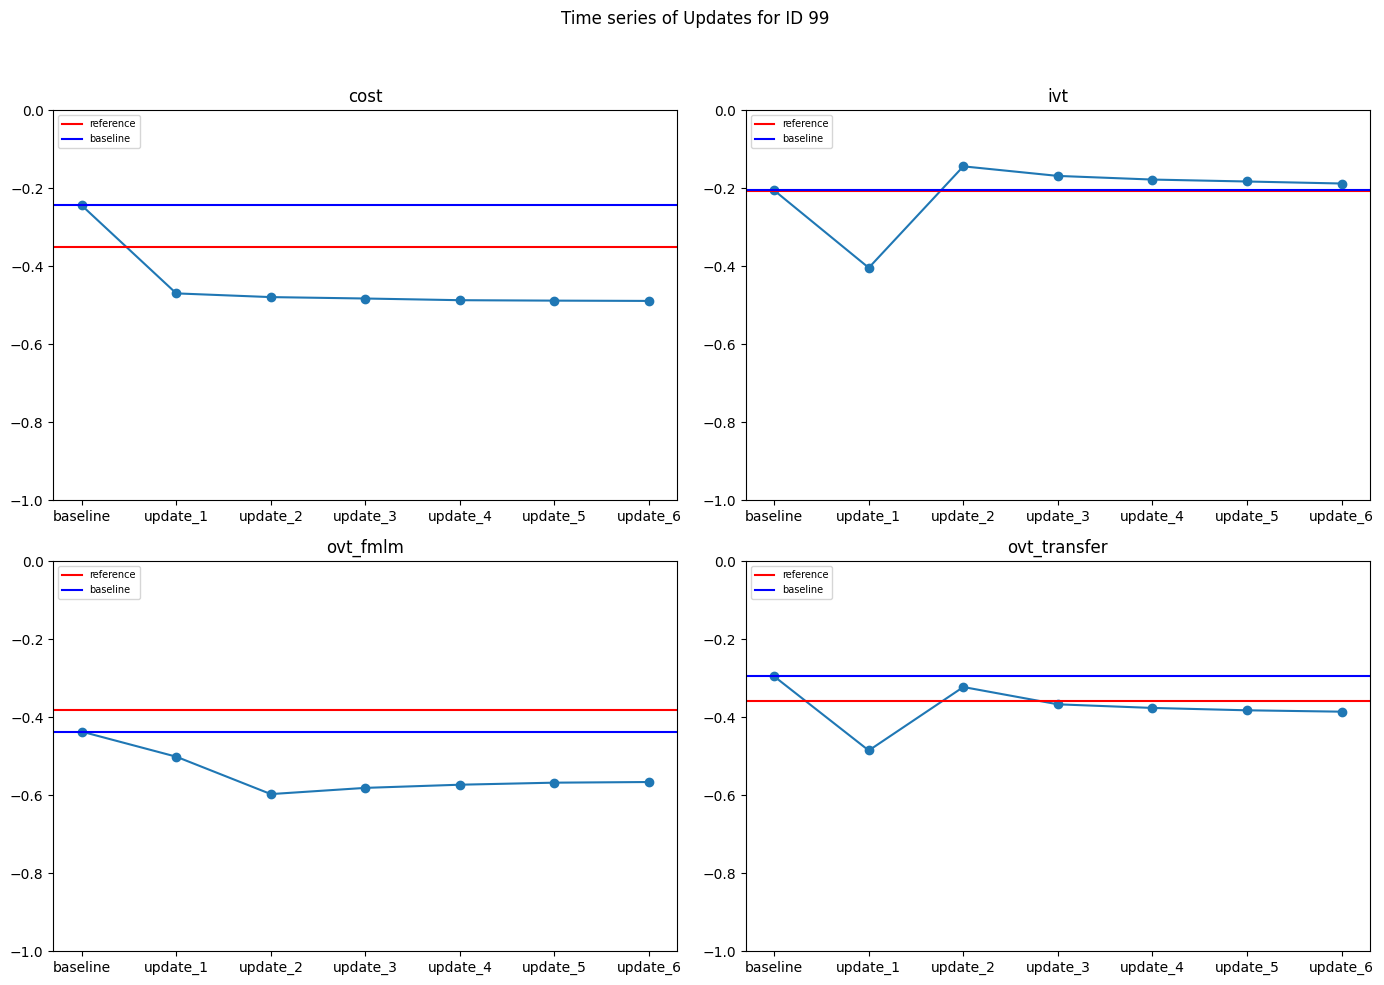

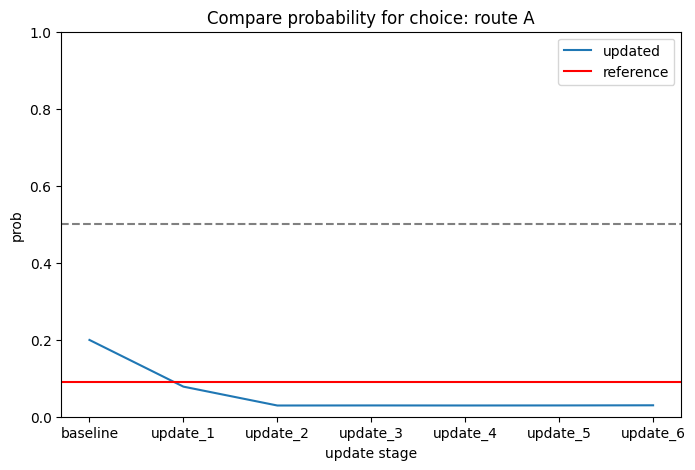



Case Study of Survey Block 3 - ID 63 : Neither correct


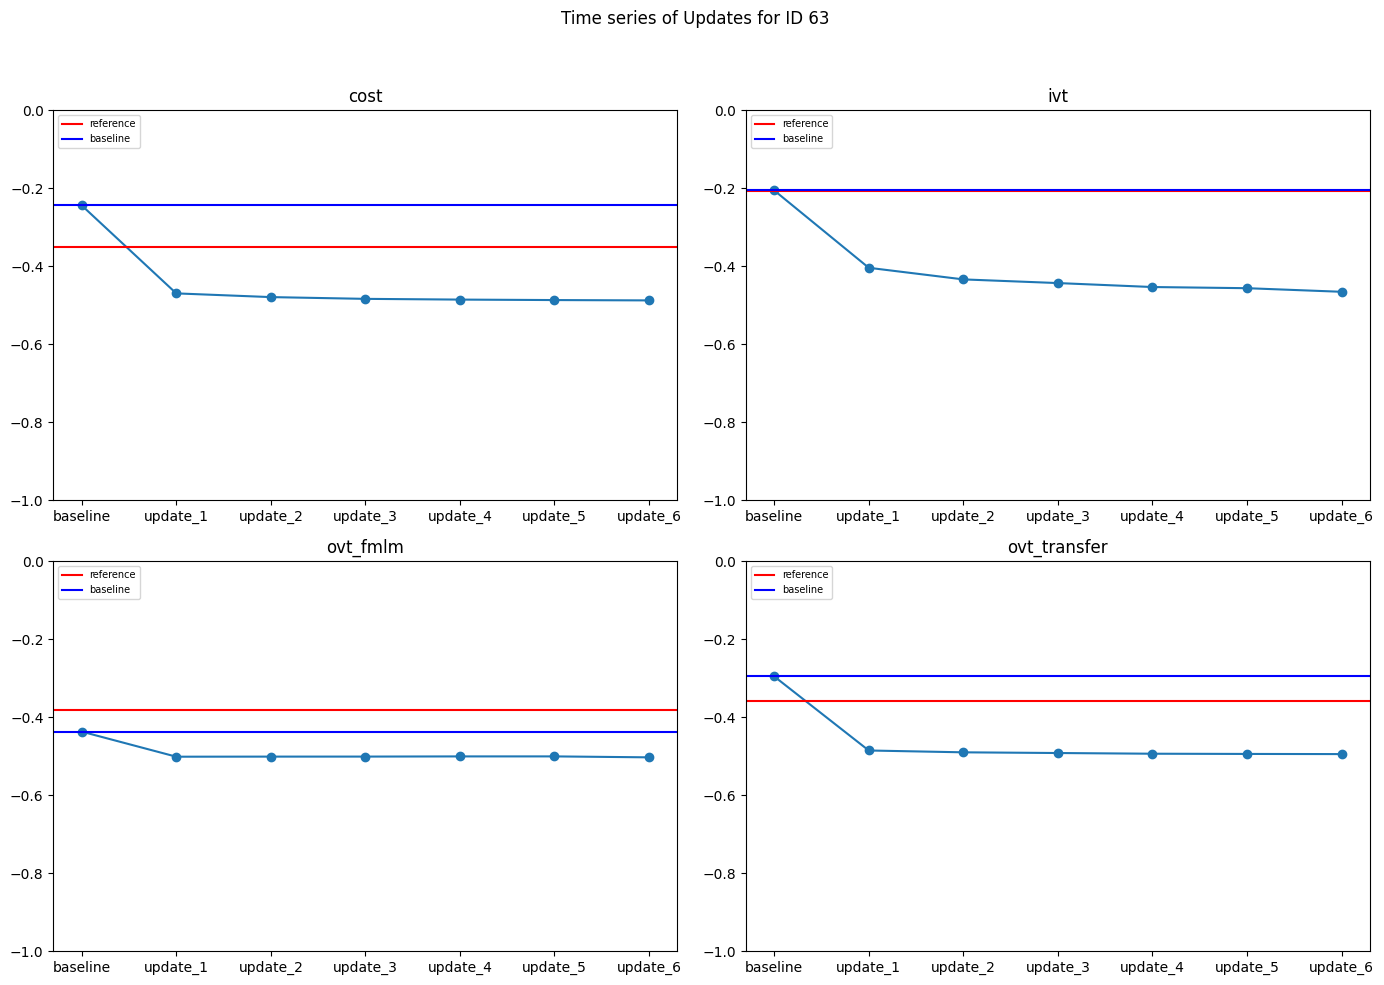

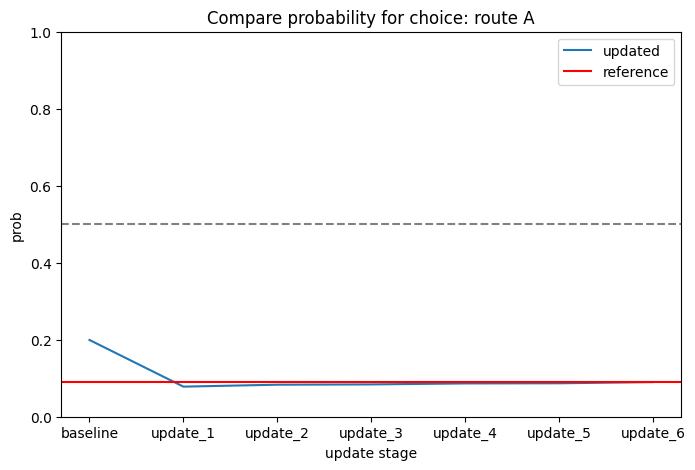

In [34]:
case_study(3)

## 5-3. Case study : block 2



Case Study of Survey Block 2 - ID 41 : Both correct


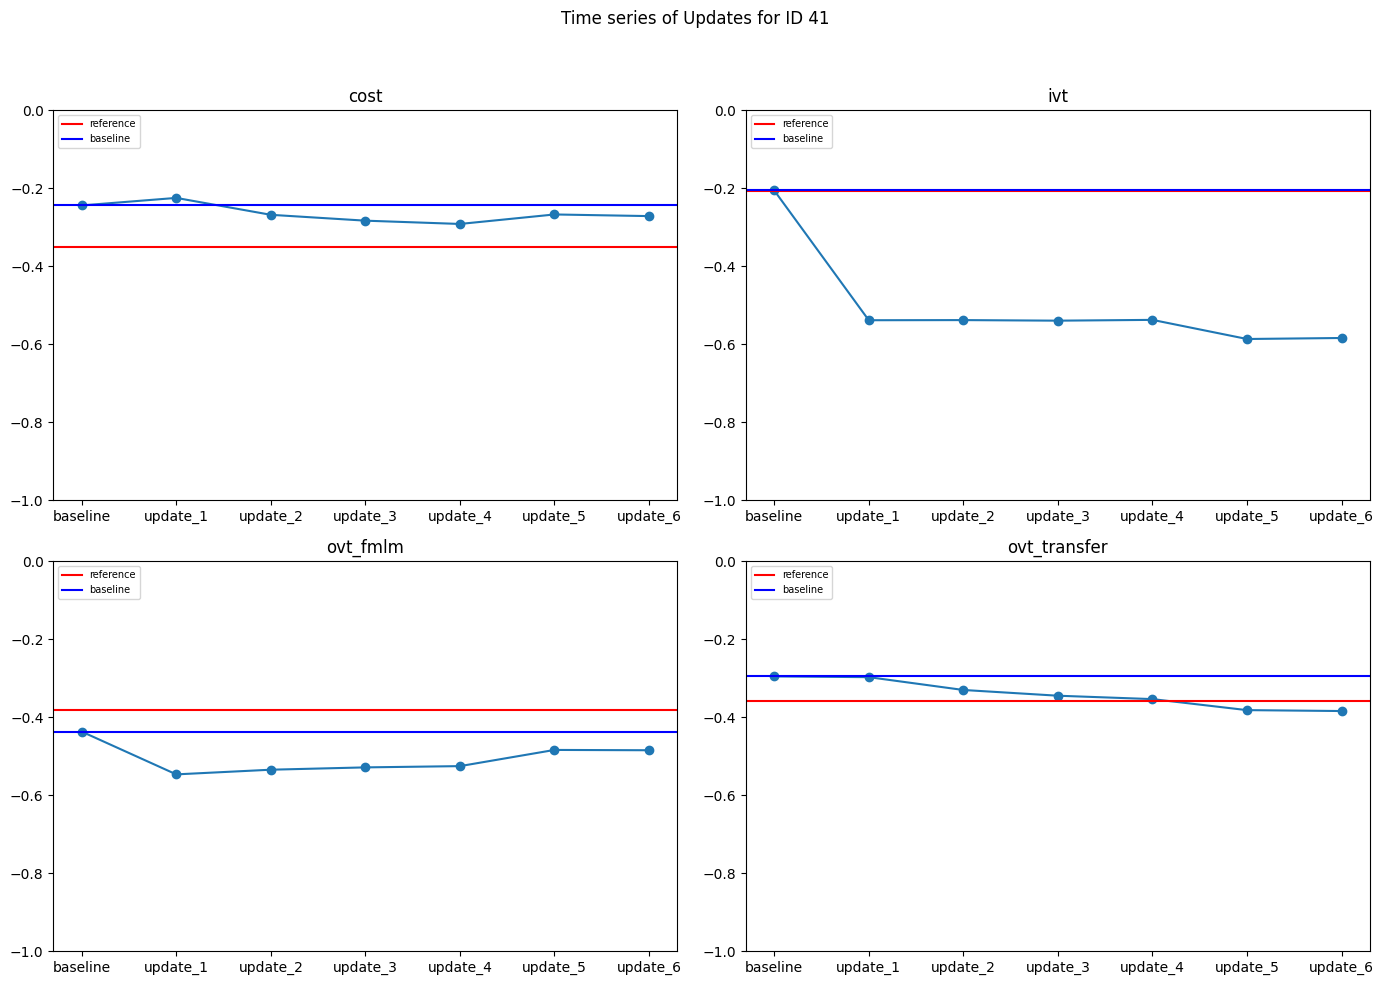

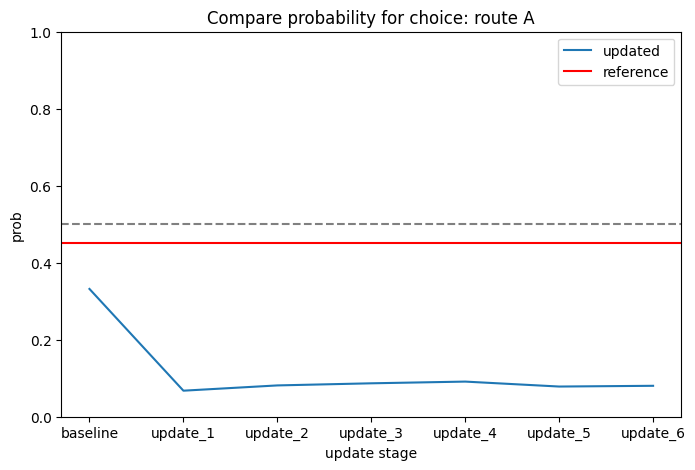



Case Study of Survey Block 2 - ID 134 : Neither correct


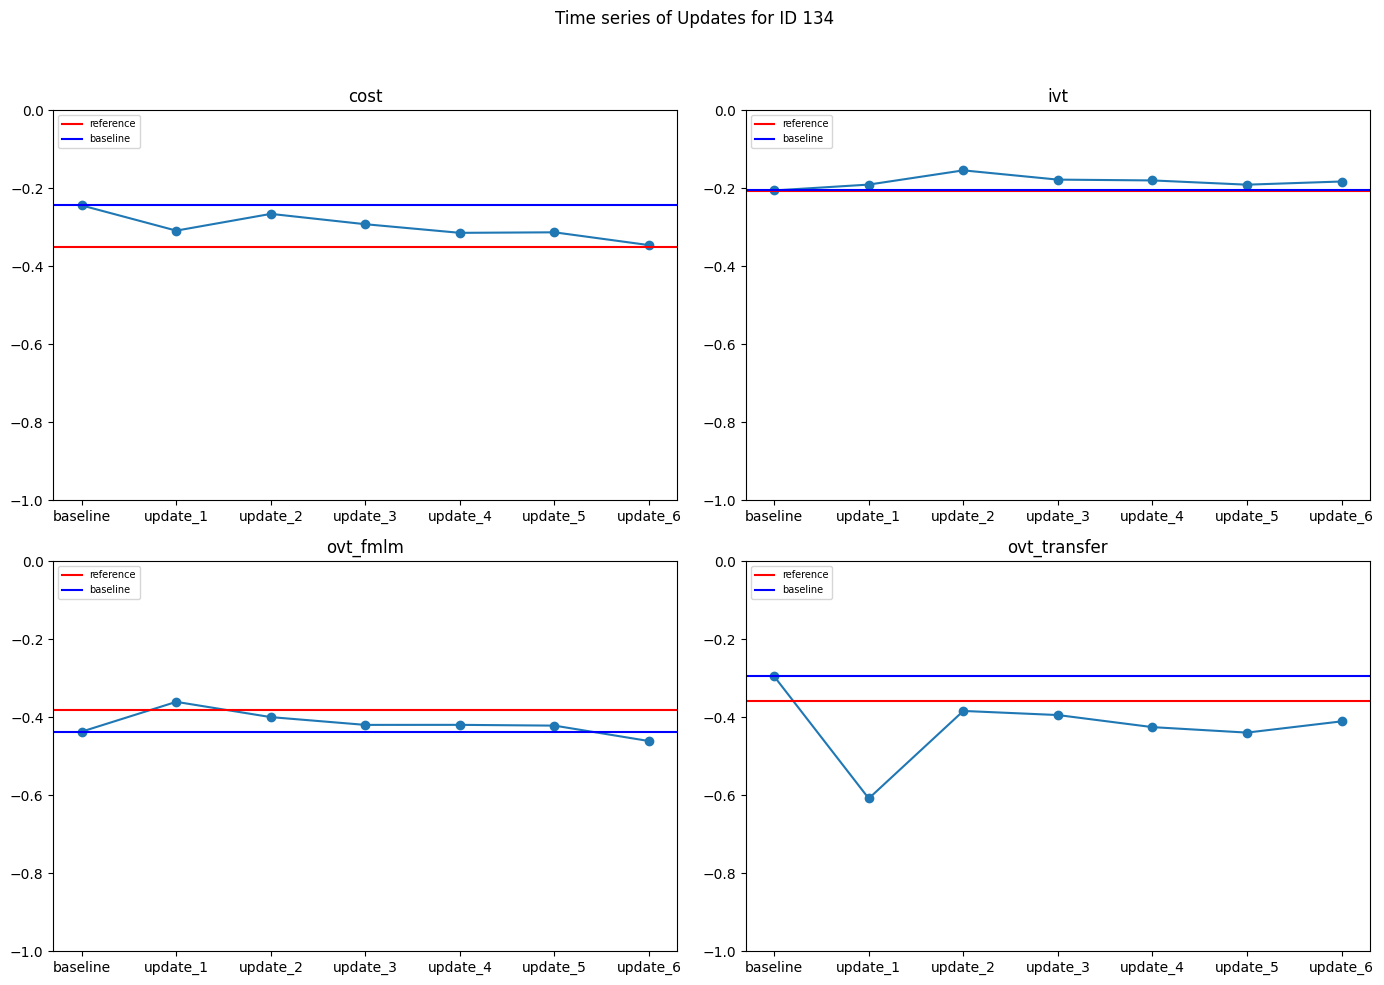

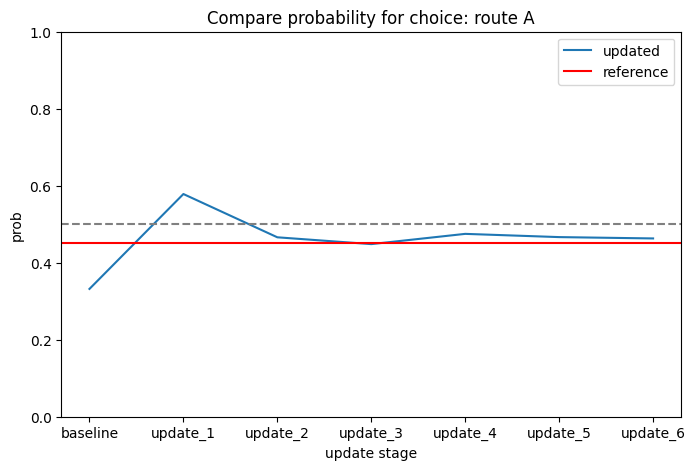



Case Study of Survey Block 2 - ID 177 : Only updated correct


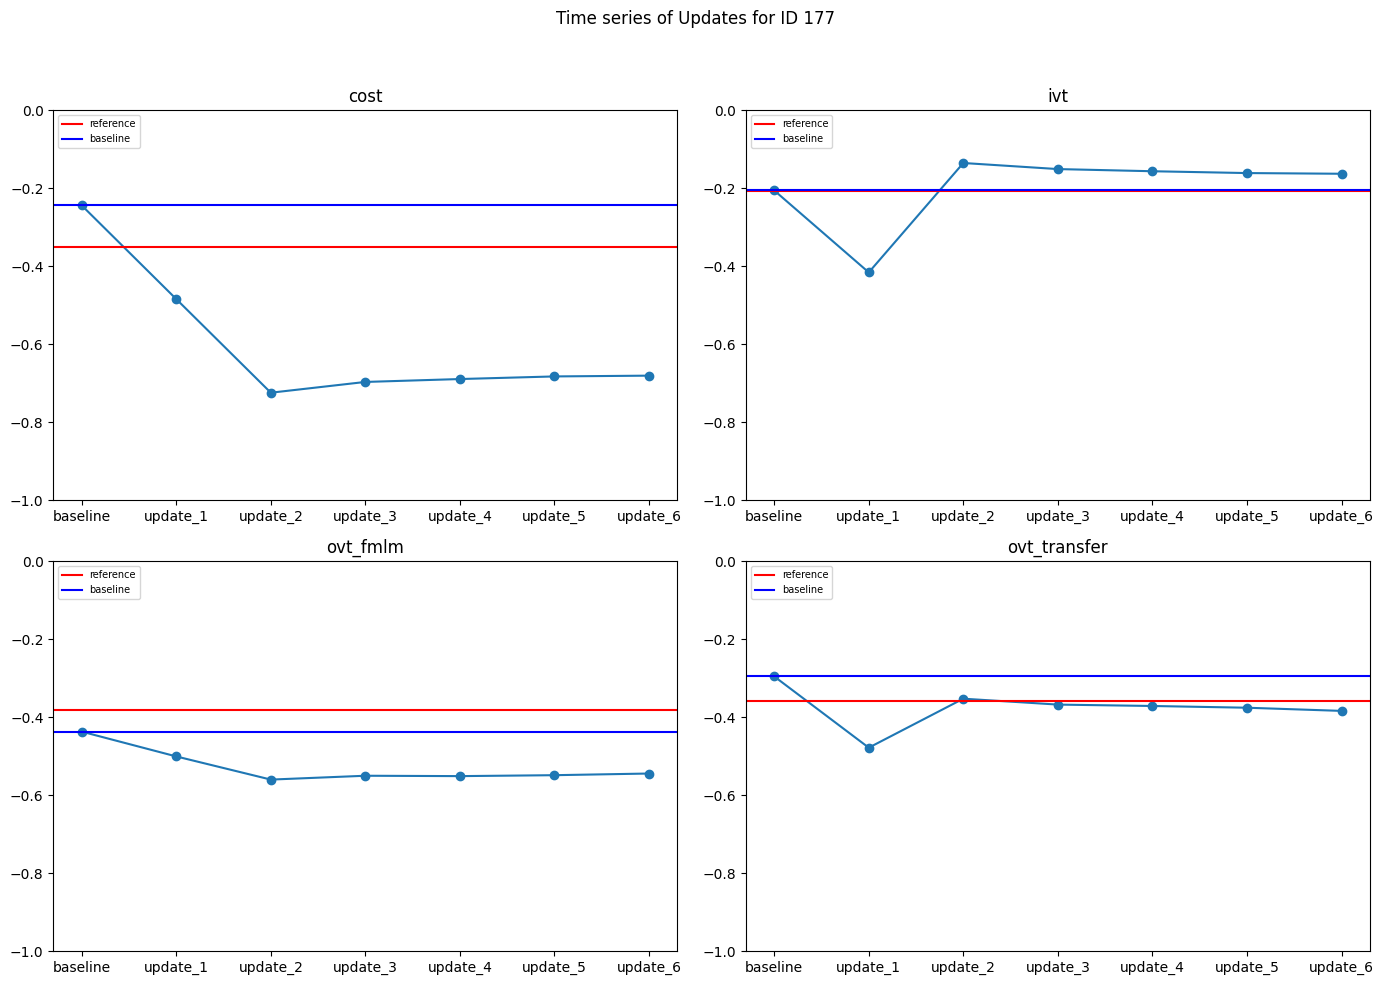

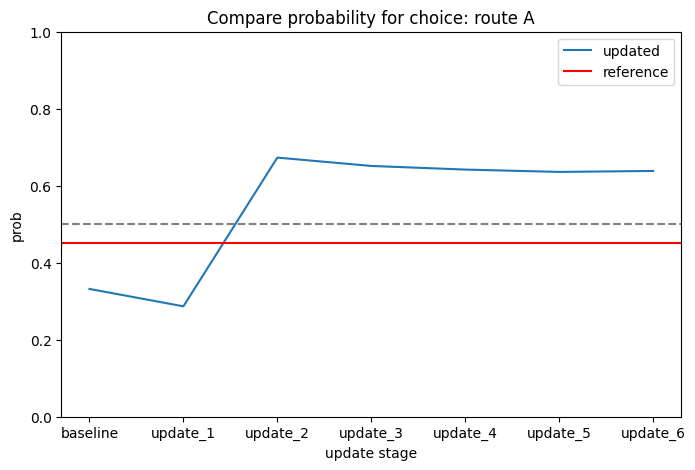



Case Study of Survey Block 2 - ID 75 : Only ref correct


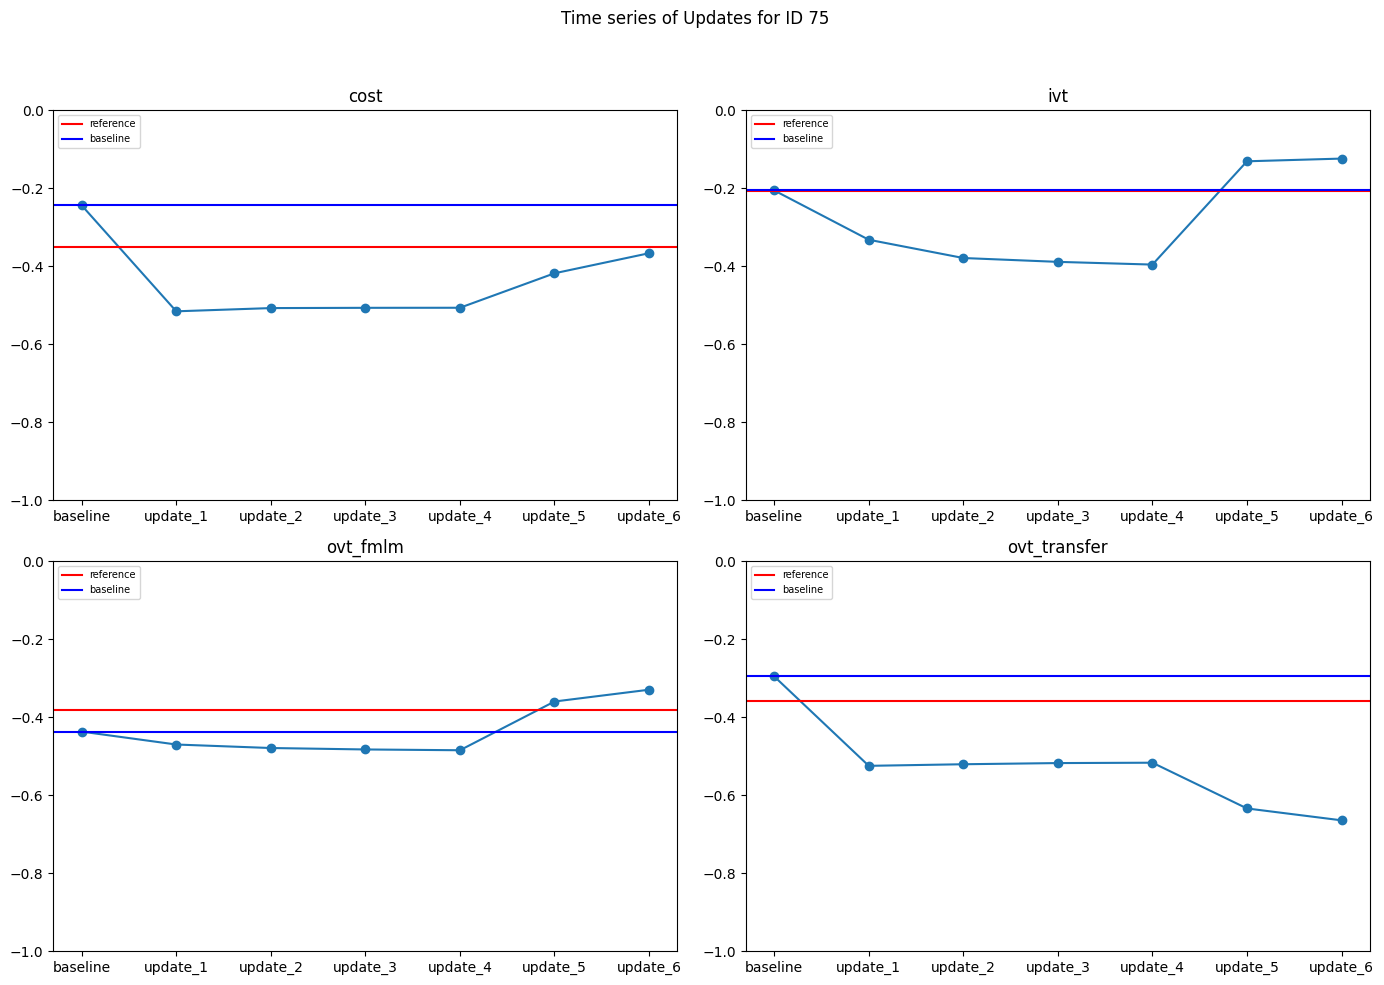

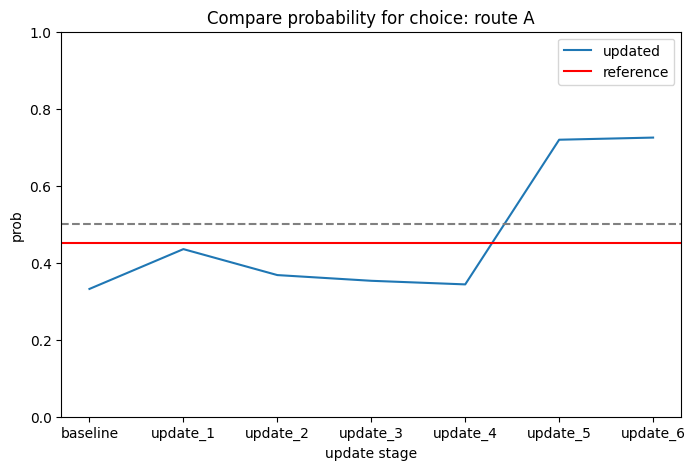

In [35]:
case_study(2)

## 5-4. Case study : block 1



Case Study of Survey Block 1 - ID 172 : Both correct


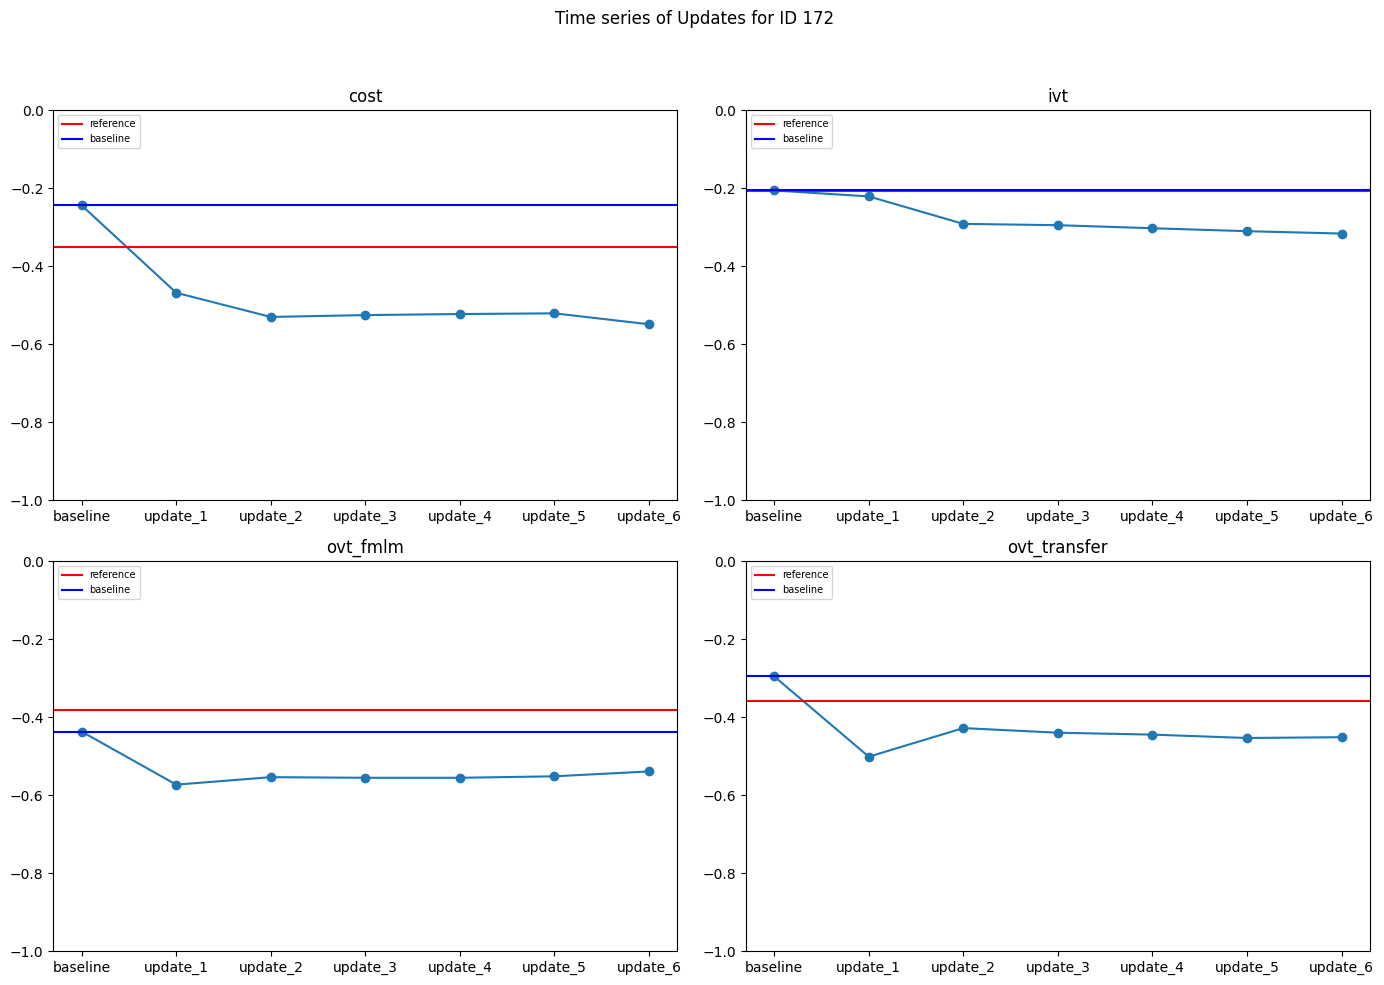

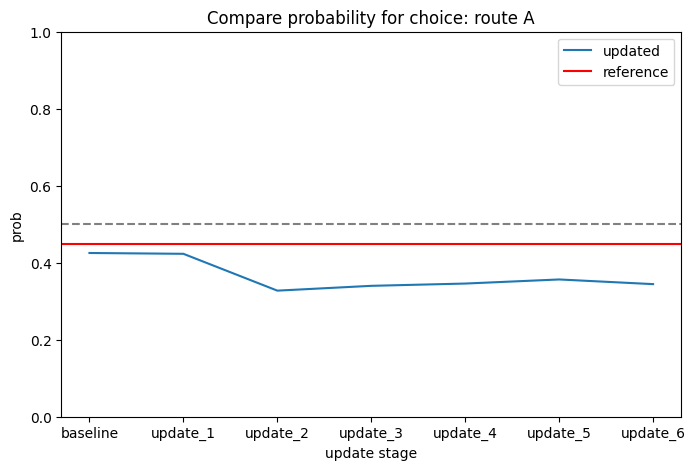



Case Study of Survey Block 1 - ID 183 : Neither correct


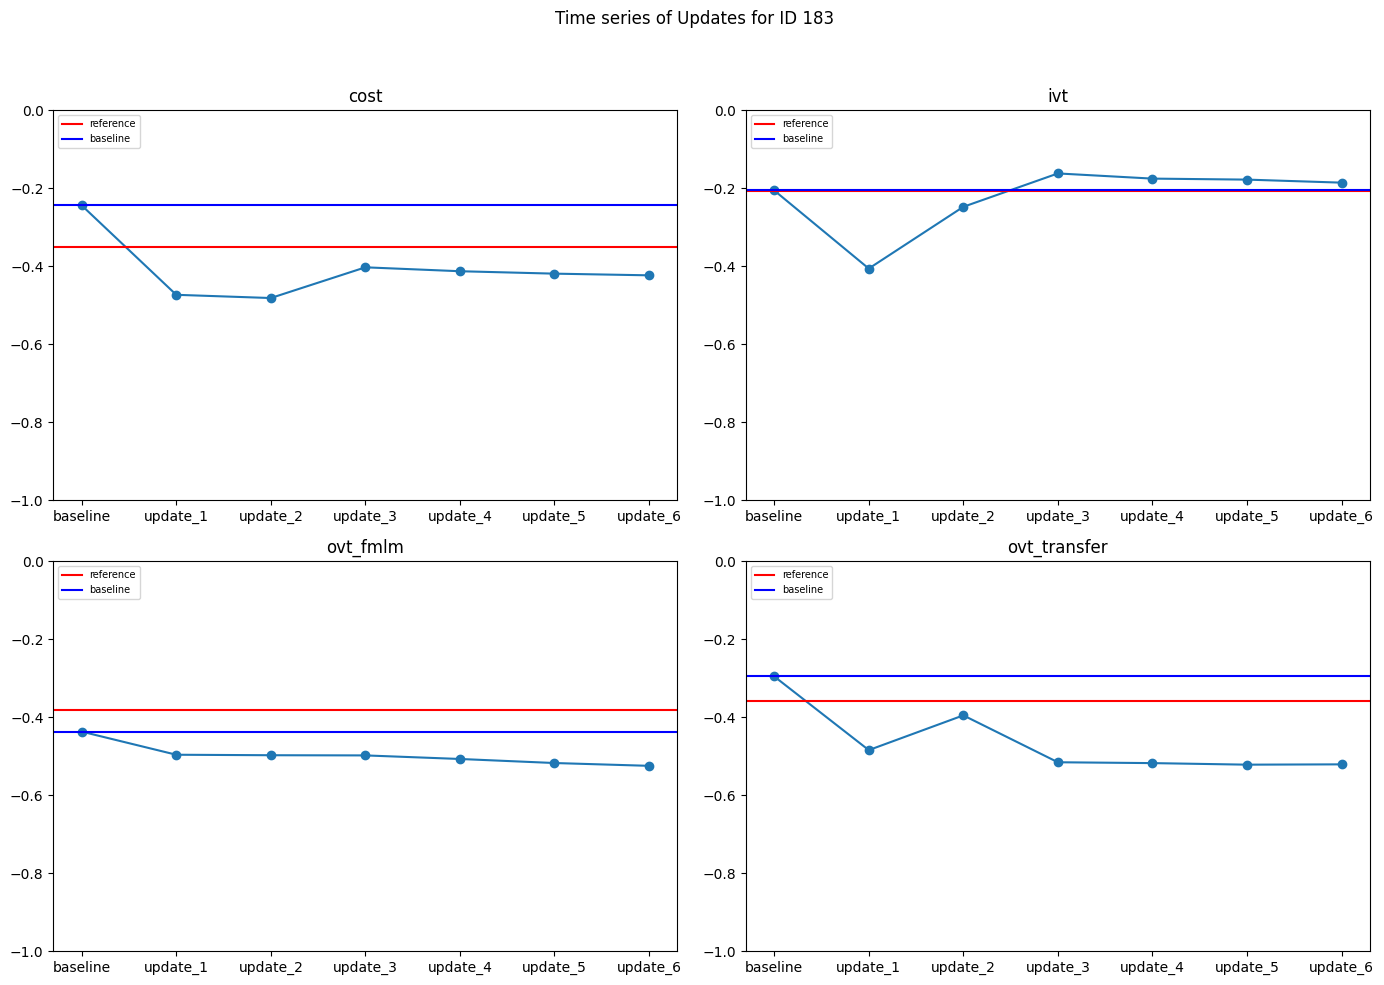

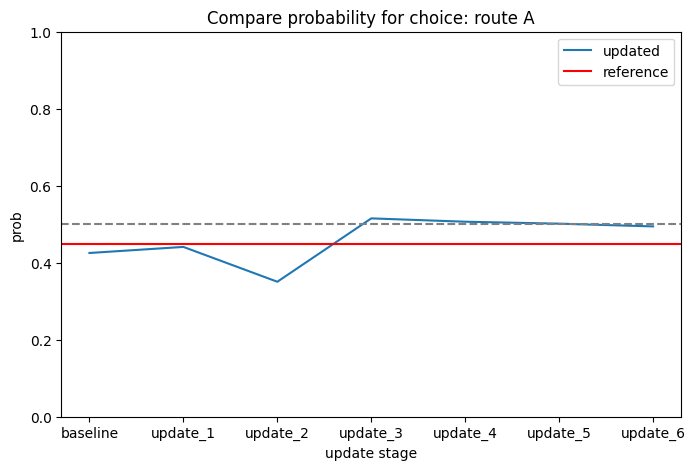



Case Study of Survey Block 1 - ID 26 : Only updated correct


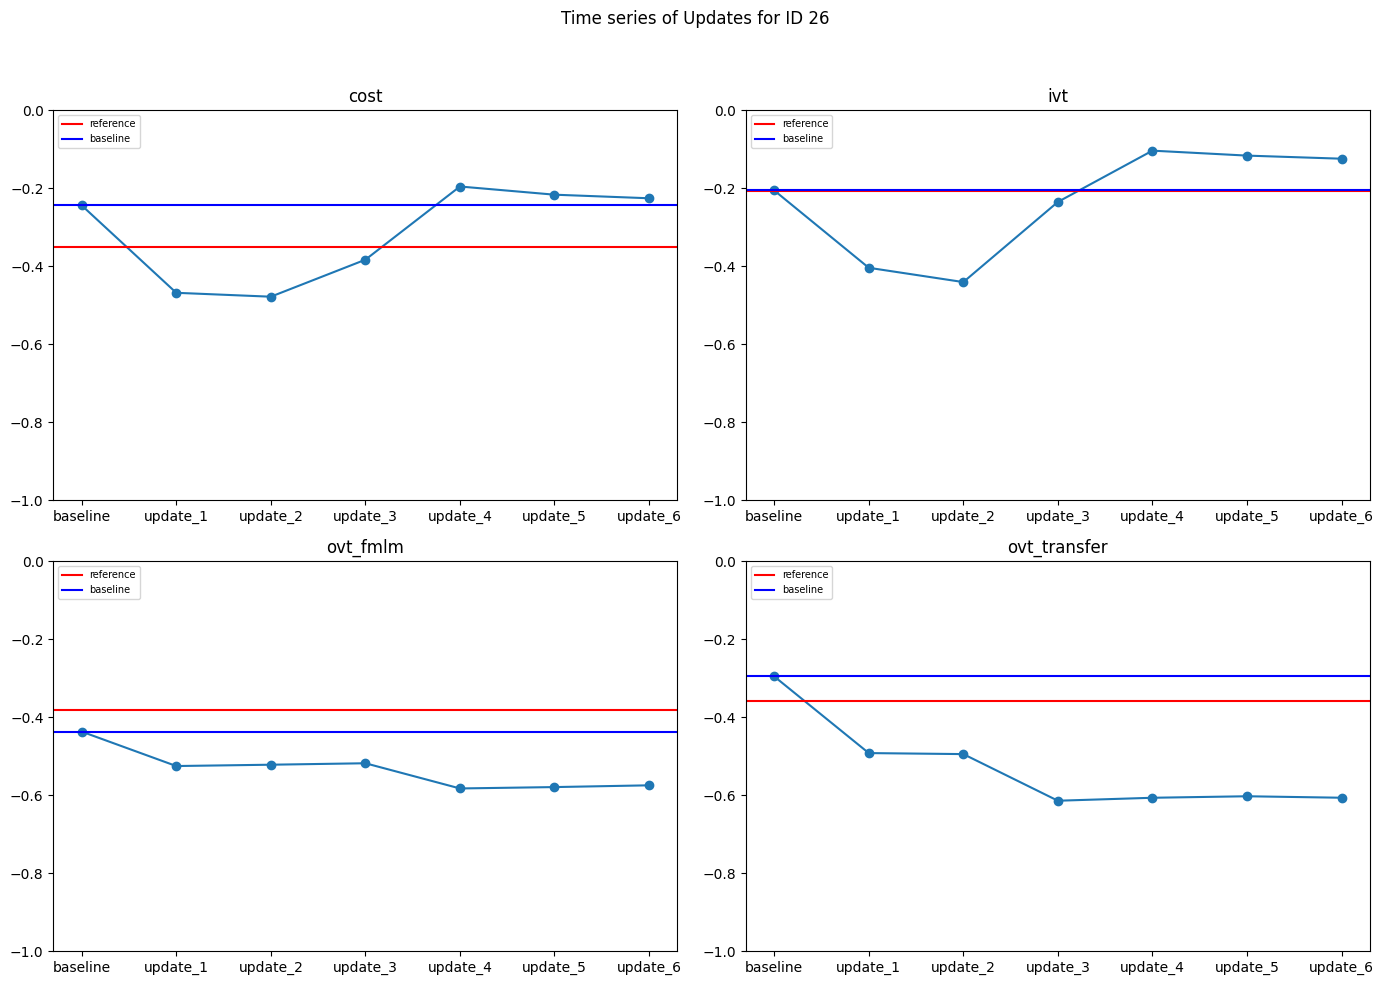

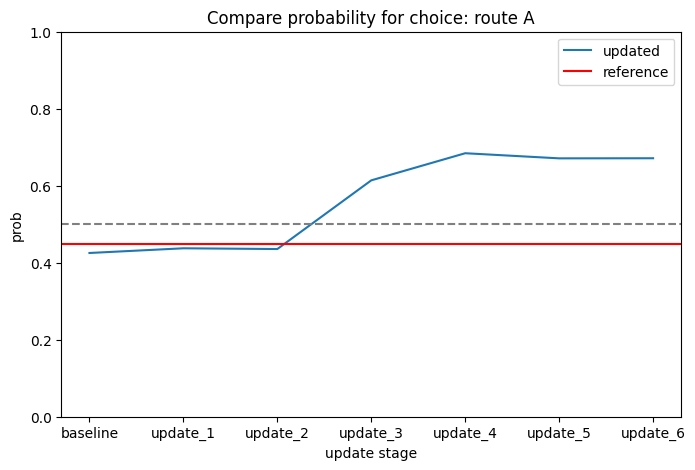



Case Study of Survey Block 1 - ID 125 : Only ref correct


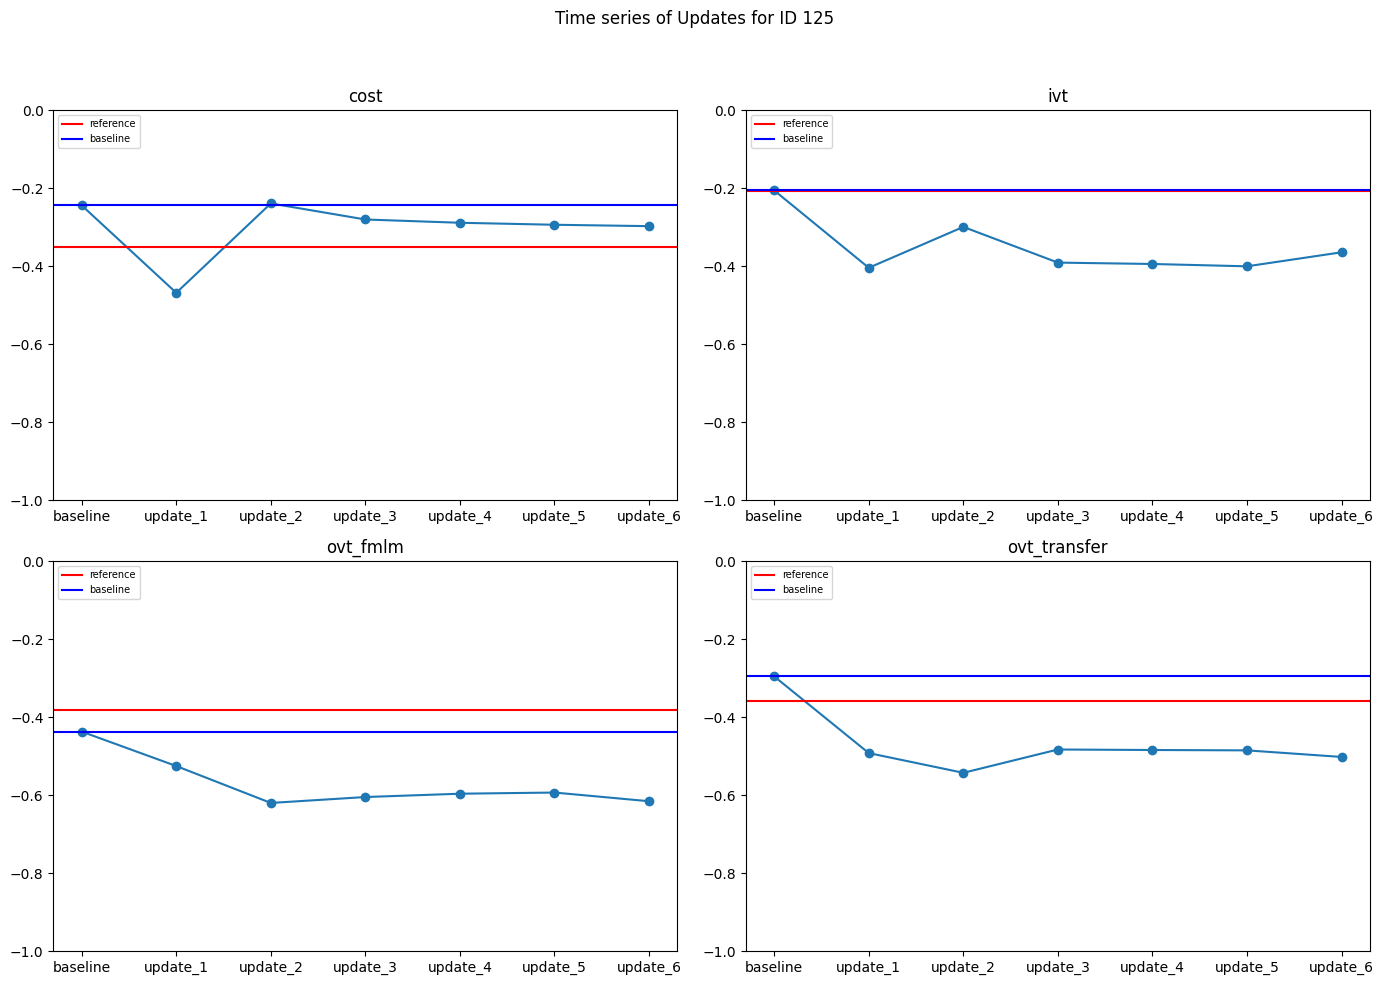

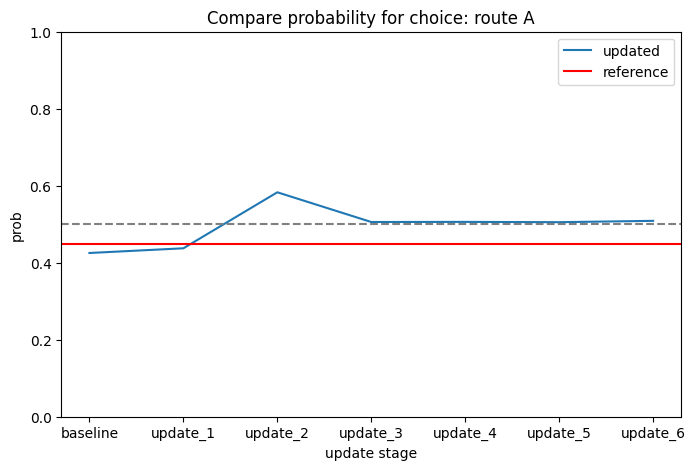

In [36]:
case_study(1)

# [6] 민감도 방향성 해석

## 6-1. Case study: block 4

In [37]:
both_correct_id_gt_1 = compare_ref_updated[(compare_ref_updated['survey_block']==4) & (compare_ref_updated['result']=='Both correct')]['ID'].values
only_updated_id_gt_0 = compare_ref_updated[(compare_ref_updated['survey_block']==4) & (compare_ref_updated['result']=='Only updated correct')]['ID'].values
print(len(both_correct_id_gt_1), len(only_updated_id_gt_0))

24 17


In [38]:
def plot_updated_parameters_separated(update_result, update_idx, both_ids, only_ids, binwidth=0.01):
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    fig.suptitle(f'Distribution of Updated parameters for {feature[update_idx]}', fontsize=13)

    # x축 범위 설정
    x_min = update_result['update_6'].min()
    x_max = update_result['update_6'].max()

    # both_correct_id_gt_1와 only_updated_id_gt_0에 해당하는 데이터 분리
    both_data = update_result[update_result['ID'].isin(both_ids)]
    only_data = update_result[update_result['ID'].isin(only_ids)]

    # 첫 번째 stage에서 y축 범위 설정
    i, row, col = 1, 0, 0
    hist_both = sns.histplot(both_data[f'update_{i}'], binwidth=binwidth, color='blue', ax=axes[row, col], stat='probability', alpha=0.5, label='choice A(=1)')
    hist_only = sns.histplot(only_data[f'update_{i}'], binwidth=binwidth, color='red', ax=axes[row, col], stat='probability', alpha=0.5, label='choice B(=0)')
    axes[row,col].axvline(x= baseline_result.params.values[update_idx], ymin=-0, ymax=1, color='orange', linestyle='--', label='baseline')
    axes[row,col].axvline(x=reference_result.params.values[update_idx], ymin=-0, ymax=1, color='green',linestyle='--', label='reference')
    axes[row, col].set_title(f'update_{i}', fontsize=10)
    axes[row, col].set_xlim(x_min, x_max)
    axes[row, col].set_xlabel('')
    y_max = max(hist_both.get_ylim()[1], hist_only.get_ylim()[1])
    axes[row, col].set_ylim(0, y_max)

    # 첫 번째 subplot에만 작은 크기의 legend 추가
    axes[row, col].legend(loc='upper left', fontsize=7)

    for i in range(2, 7):
        row = (i - 1) // 3
        col = (i - 1) % 3
        sns.histplot(both_data[f'update_{i}'], binwidth=binwidth, color='blue', ax=axes[row, col], stat='probability', alpha=0.5)
        sns.histplot(only_data[f'update_{i}'], binwidth=binwidth, color='red', ax=axes[row, col], stat='probability', alpha=0.5)
        axes[row,col].axvline(x= baseline_result.params.values[update_idx], ymin=-0, ymax=1, color='orange', linestyle='--', label='baseline')
        axes[row,col].axvline(x=reference_result.params.values[update_idx], ymin=-0, ymax=1, color='green',linestyle='--', label='reference')

        axes[row, col].set_title(f'update_{i}', fontsize=10)
        axes[row, col].set_xlim(x_min, x_max)
        axes[row, col].set_ylim(0, y_max)
        axes[row, col].set_xlabel('')
        if i != 4:
            axes[row, col].set_ylabel('')

    plt.tight_layout()
    plt.show()

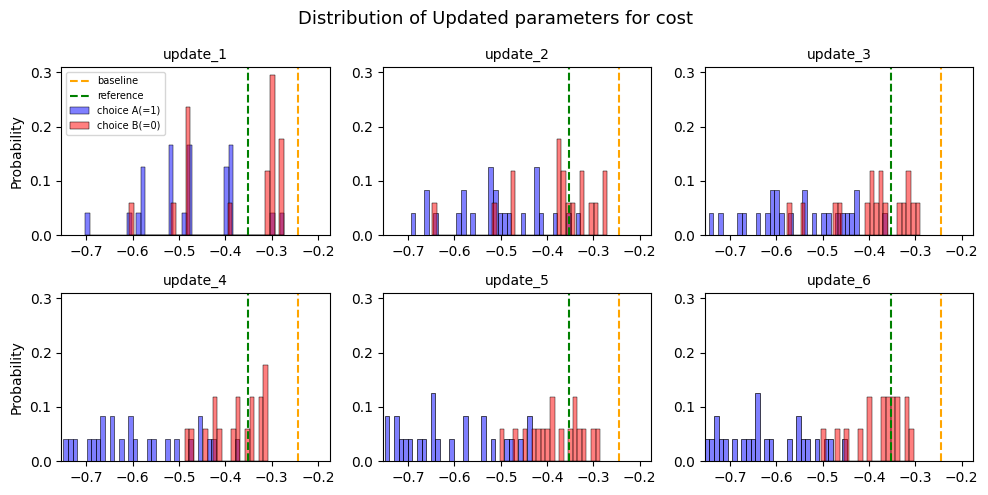

In [39]:
plot_updated_parameters_separated(cost_mean_update_result, 0, both_correct_id_gt_1, only_updated_id_gt_0)


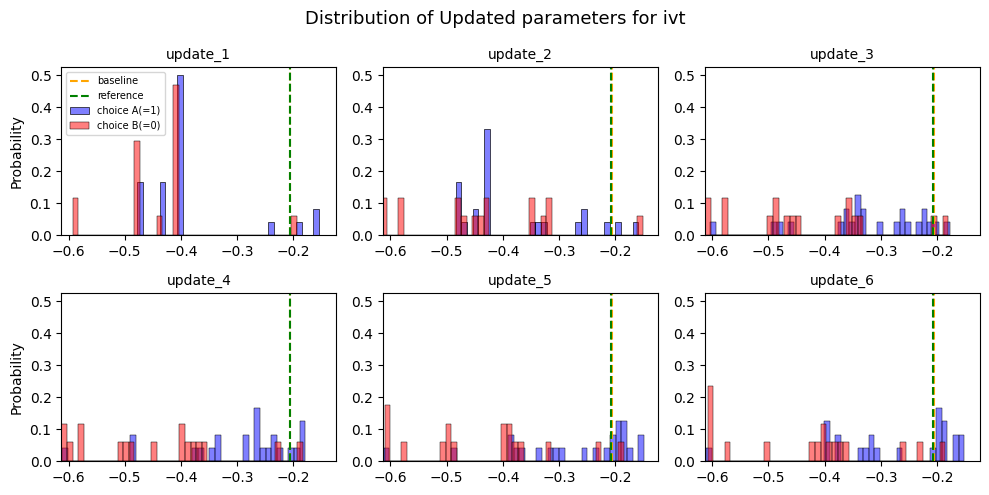

In [40]:
plot_updated_parameters_separated(ivt_mean_update_result, 1, both_correct_id_gt_1, only_updated_id_gt_0)

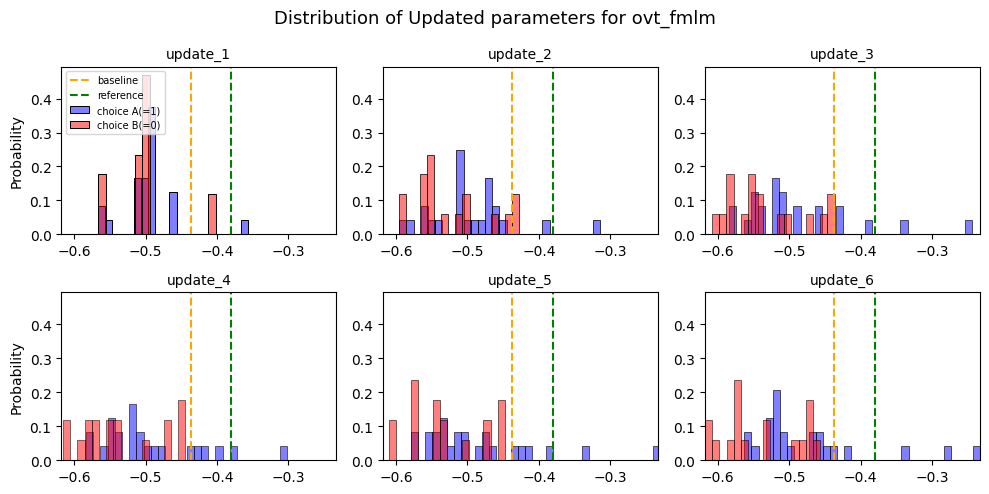

In [41]:
plot_updated_parameters_separated(ovt_fmlm_mean_update_result, 2, both_correct_id_gt_1, only_updated_id_gt_0)

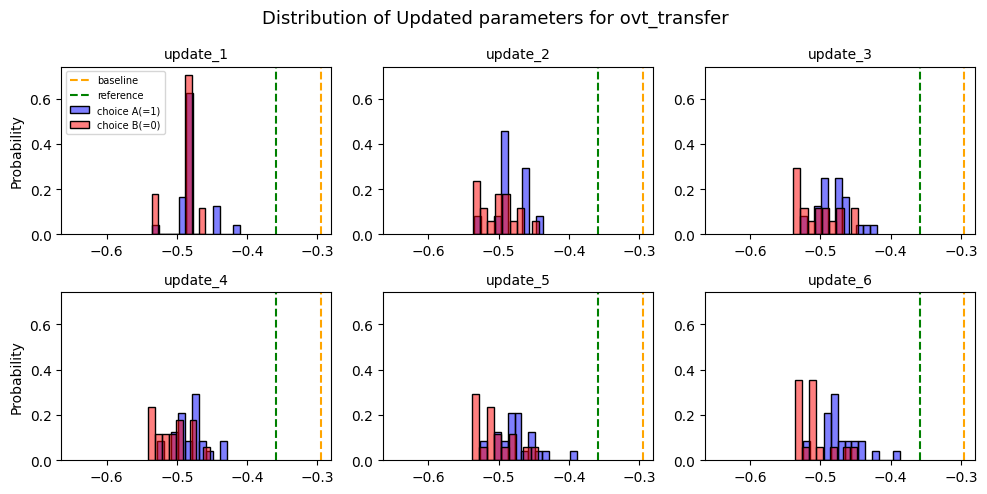

In [42]:
plot_updated_parameters_separated(ovt_transfer_mean_update_result, 3, both_correct_id_gt_1, only_updated_id_gt_0)

## 6-2. Case study: block 3

In [43]:
both_correct_id_gt_1 = compare_ref_updated[(compare_ref_updated['survey_block']==3) & (compare_ref_updated['result']=='Both correct')]['ID'].values
only_updated_id_gt_0 = compare_ref_updated[(compare_ref_updated['survey_block']==3) & (compare_ref_updated['result']=='Only updated correct')]['ID'].values
print(len(both_correct_id_gt_1), len(only_updated_id_gt_0))

# updated만 맞은게 없어서 해석 불가능

33 0


## 6-3. Case study: block 2

In [44]:
both_correct_id_gt_1 = compare_ref_updated[(compare_ref_updated['survey_block']==2) & (compare_ref_updated['result']=='Both correct')]['ID'].values
only_updated_id_gt_0 = compare_ref_updated[(compare_ref_updated['survey_block']==2) & (compare_ref_updated['result']=='Only updated correct')]['ID'].values
print(len(both_correct_id_gt_1), len(only_updated_id_gt_0))

21 6


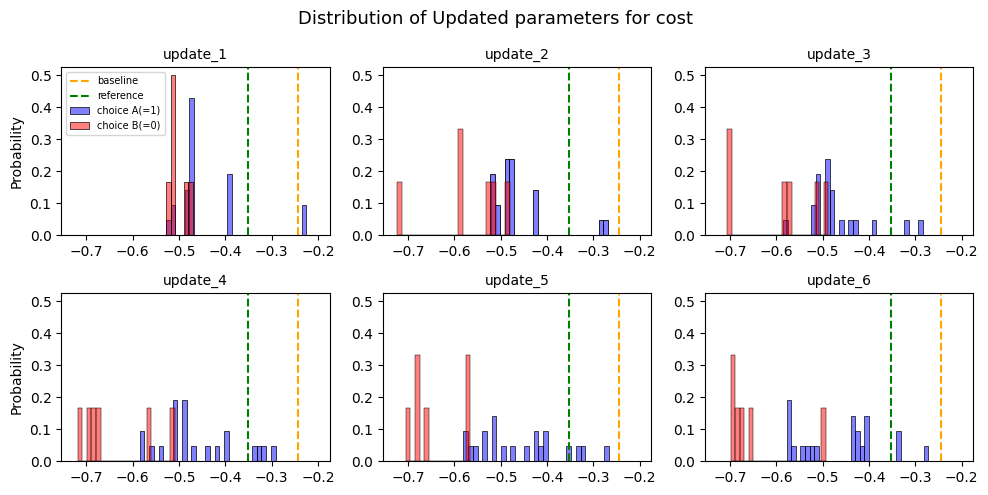

In [45]:
plot_updated_parameters_separated(cost_mean_update_result, 0, both_correct_id_gt_1, only_updated_id_gt_0)

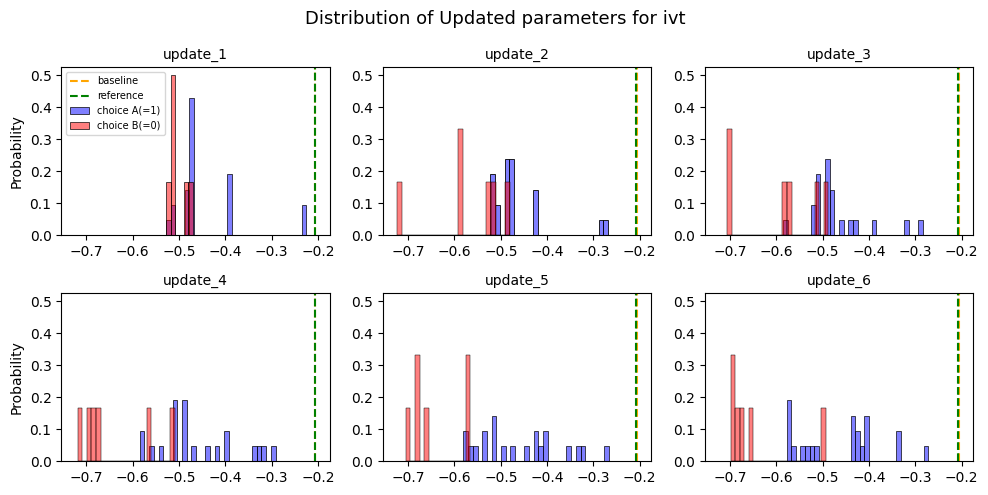

In [46]:
plot_updated_parameters_separated(cost_mean_update_result, 1, both_correct_id_gt_1, only_updated_id_gt_0)

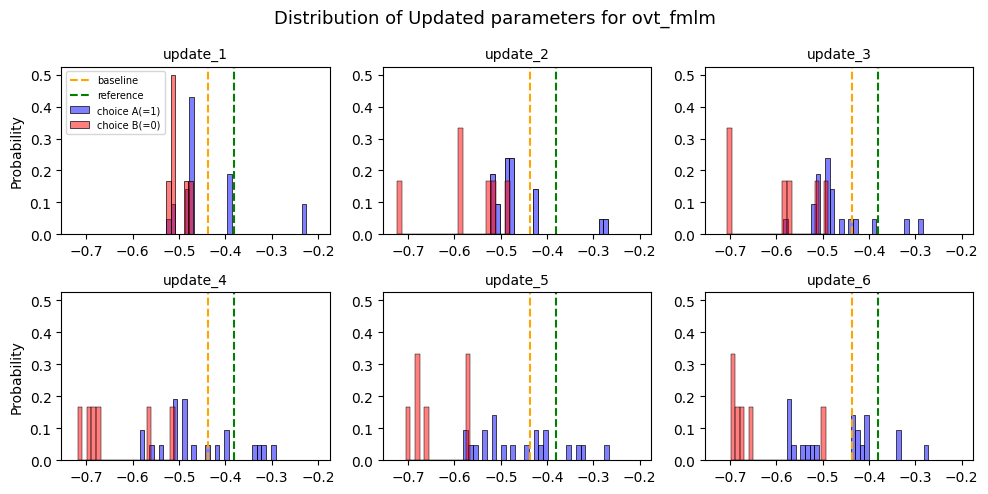

In [47]:

plot_updated_parameters_separated(cost_mean_update_result, 2, both_correct_id_gt_1, only_updated_id_gt_0)

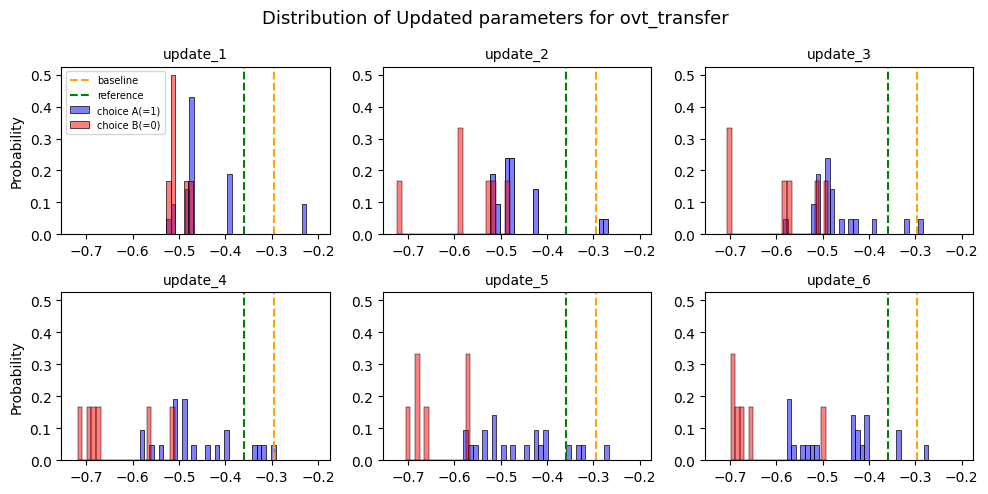

In [48]:
plot_updated_parameters_separated(cost_mean_update_result, 3, both_correct_id_gt_1, only_updated_id_gt_0)

## 6-4. Case study: block 1


In [49]:
both_correct_id_gt_1 = compare_ref_updated[(compare_ref_updated['survey_block']==1) & (compare_ref_updated['result']=='Both correct')]['ID'].values
only_updated_id_gt_0 = compare_ref_updated[(compare_ref_updated['survey_block']==1) & (compare_ref_updated['result']=='Only updated correct')]['ID'].values
print(len(both_correct_id_gt_1), len(only_updated_id_gt_0))

29 10


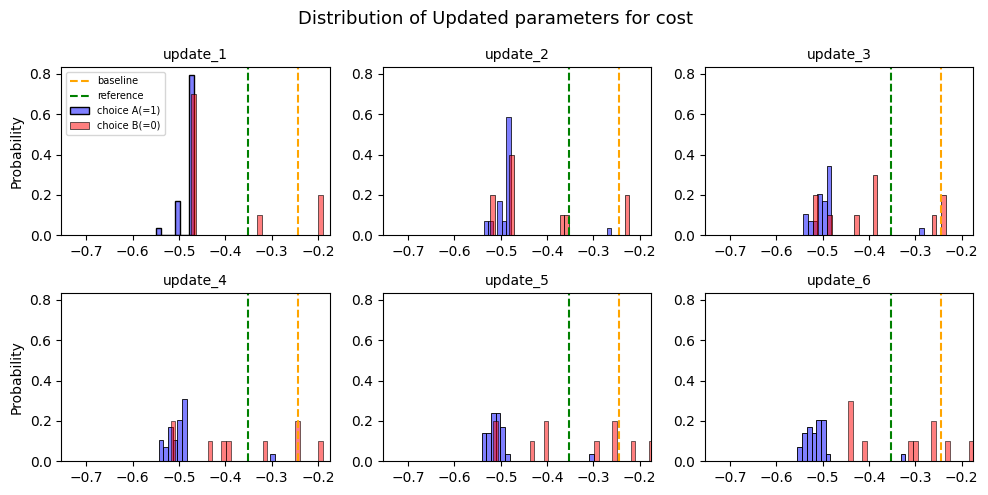

In [50]:
plot_updated_parameters_separated(cost_mean_update_result, 0, both_correct_id_gt_1, only_updated_id_gt_0)

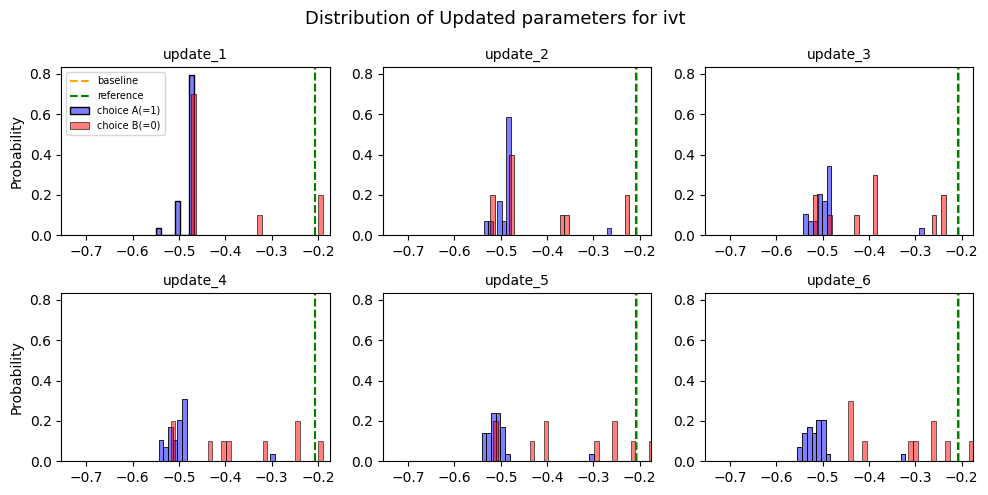

In [51]:
plot_updated_parameters_separated(cost_mean_update_result, 1, both_correct_id_gt_1, only_updated_id_gt_0)

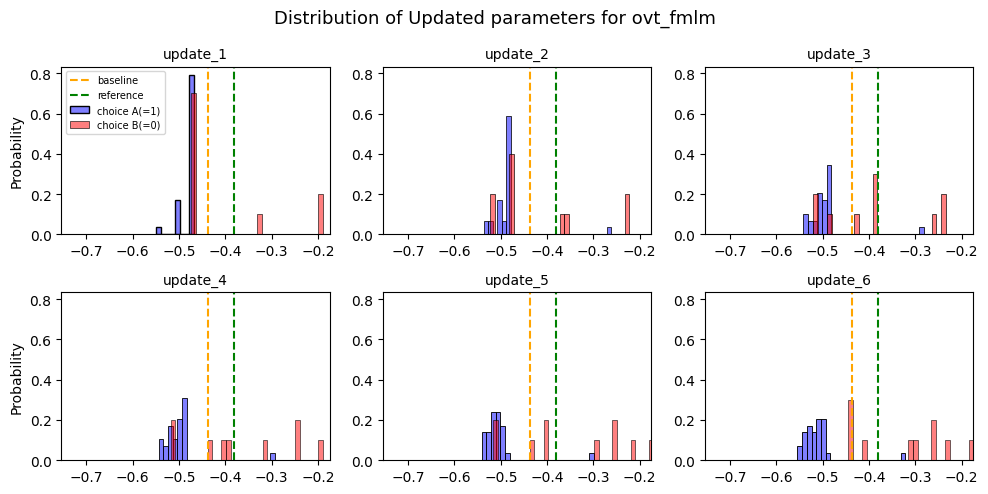

In [52]:
plot_updated_parameters_separated(cost_mean_update_result, 2, both_correct_id_gt_1, only_updated_id_gt_0)

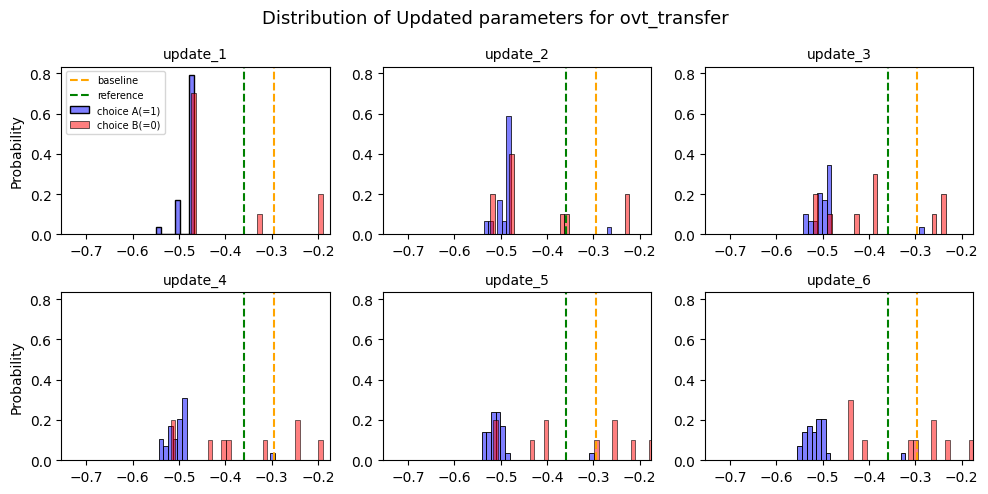

In [53]:
plot_updated_parameters_separated(cost_mean_update_result, 3, both_correct_id_gt_1, only_updated_id_gt_0)

# [7] 효용 변화

In [54]:
A=[17.5, 50, 16, 6]
B=[22.5, 50, 10, 8]

In [55]:
print([A[i]*reference_result.params.values[i] for i in range(4)])
print([B[i]*reference_result.params.values[i] for i in range(4)])

[-6.157871991655283, -10.351788030467205, -6.086955642948588, -2.154271162562398]
[-7.917263989271078, -10.351788030467205, -3.8043472768428677, -2.872361550083197]


In [56]:
a_util=[A[i]*reference_result.params.values[i] for i in range(4)]
b_util=[B[i]*reference_result.params.values[i] for i in range(4)]
for i in range(4):
  if a_util[i]>b_util[i]: print(f'A has {a_util[i]-b_util[i]:.2f} greater utility in terms of {feature[i]}')
  elif a_util[i]==b_util[i]: print(f'A and B has same utility in terms of {feature[i]}')
  else: print(f'B has {b_util[i]-a_util[i]:.2f} greater utility in terms of {feature[i]}')

A has 1.76 greater utility in terms of cost
A and B has same utility in terms of ivt
B has 2.28 greater utility in terms of ovt_fmlm
A has 0.72 greater utility in terms of ovt_transfer


In [57]:
update_mean_result=[cost_mean_update_result, ivt_mean_update_result, ovt_fmlm_mean_update_result, ovt_transfer_mean_update_result]

In [64]:
for id in [182, 32, 106,176]:
  print(id)
  print([round(update_mean_result[i].loc[id,'update_6'],4) for i in range(4)])

182
[-0.6617, -0.3161, -0.2749, -0.4247]
32
[-0.341, -0.3967, -0.5677, -0.5261]
106
[-0.338, -0.3746, -0.4657, -0.5378]
176
[-0.3683, -0.6006, -0.4759, -0.5125]


In [65]:
# Both correct 182
# Both incorrect 176
# Only updated 32
# Only reference 106

for id in [182, 32, 106,176]:
  print(id)
  a_util = [A[i]*update_mean_result[i].loc[id,'update_6'] for i in range(4)]
  b_util = [B[i]*update_mean_result[i].loc[id,'update_6'] for i in range(4)]
  for i in range(4):
    if a_util[i]>b_util[i]: print(f'A has {a_util[i]-b_util[i]:.2f} greater utility in terms of {feature[i]}')
    elif a_util[i]==b_util[i]: print(f'A and B has same utility in terms of {feature[i]}')
    else: print(f'B has {b_util[i]-a_util[i]:.2f} greater utility in terms of {feature[i]}')
  print('')


182
A has 3.31 greater utility in terms of cost
A and B has same utility in terms of ivt
B has 1.65 greater utility in terms of ovt_fmlm
A has 0.85 greater utility in terms of ovt_transfer

32
A has 1.71 greater utility in terms of cost
A and B has same utility in terms of ivt
B has 3.41 greater utility in terms of ovt_fmlm
A has 1.05 greater utility in terms of ovt_transfer

106
A has 1.69 greater utility in terms of cost
A and B has same utility in terms of ivt
B has 2.79 greater utility in terms of ovt_fmlm
A has 1.08 greater utility in terms of ovt_transfer

176
A has 1.84 greater utility in terms of cost
A and B has same utility in terms of ivt
B has 2.86 greater utility in terms of ovt_fmlm
A has 1.03 greater utility in terms of ovt_transfer

